In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 
import os 
from scipy.stats import wilcoxon, ttest_rel
from tabulate import tabulate
from functions.test_algorithms import test_slim
from slim_gsgp_lib.utils.utils import train_test_split
from slim_gsgp_lib.datasets.data_loader import *
datasets = [globals()[i] for i in globals() if 'load' in i][2:]
datasets = datasets[:12] + datasets[13:]  # EXCLUDE PARKINSONS

dataset_dict = {}
df_datasets = {}
for i, dataset in enumerate(datasets):
    X,y = dataset()
    name = dataset.__name__.split('load_')[1]
    # id should be a two digit number
    id = 'DA' + str(i).zfill(2)
    dataset_dict[name] = id 
    df_datasets[name] = X.shape[0], X.shape[1]

df_datasets

{'resid_build_sale_price': (372, 107),
 'istanbul': (536, 7),
 'airfoil': (1503, 5),
 'bike_sharing': (731, 13),
 'boston': (506, 13),
 'breast_cancer': (569, 30),
 'concrete_slump': (103, 7),
 'concrete_strength': (1005, 8),
 'diabetes': (442, 10),
 'efficiency_heating': (768, 8),
 'efficiency_cooling': (768, 8),
 'forest_fires': (513, 43),
 'ld50': (234, 626),
 'ppb': (131, 626),
 'bioav': (358, 241)}

### Differences in scale

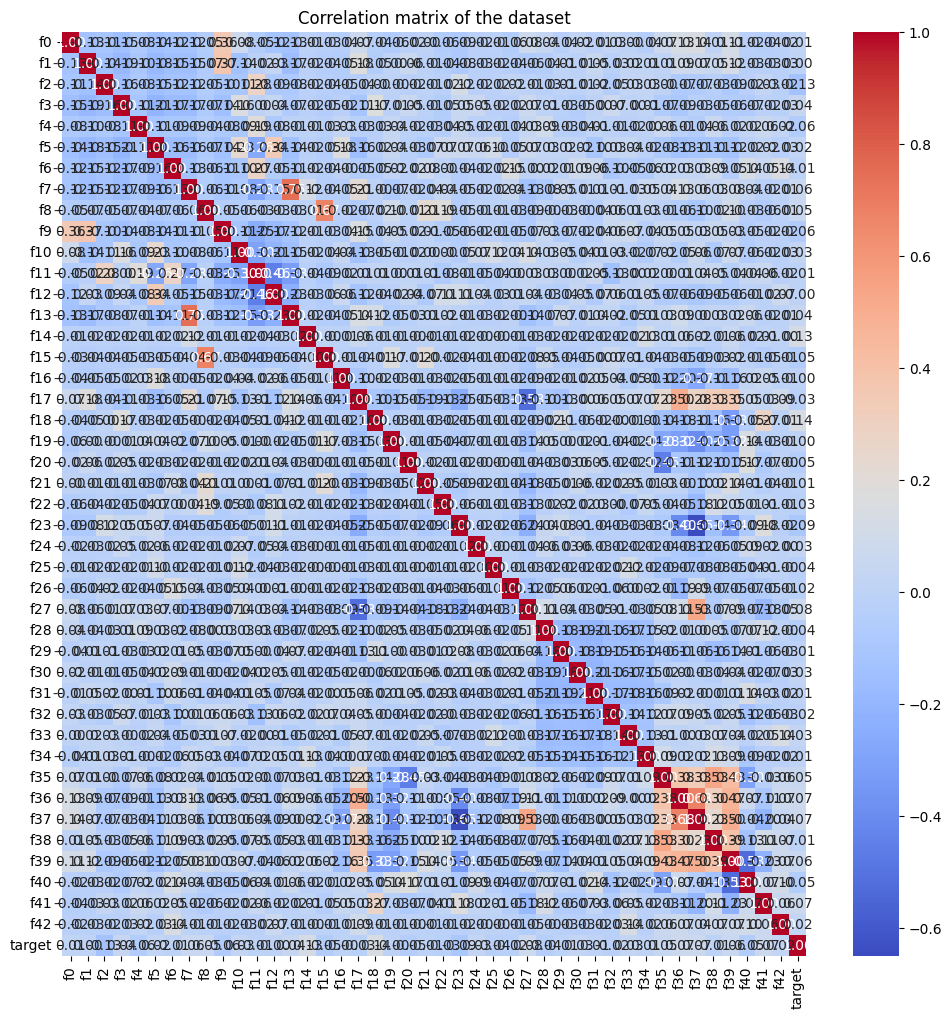

In [2]:
X,y = datasets[11]()

# Check the correlation matrix of the dataset
X = pd.DataFrame(X, columns=[f'f{i}' for i in range(X.shape[1])])
y = pd.DataFrame(y, columns=['target'])
full_data = pd.concat([X, y], axis=1)
corr = full_data.corr()
plt.figure(figsize=(12,12))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation matrix of the dataset')
plt.show()

In [3]:
df_stats = pd.DataFrame()

for dataset in datasets:
    X,y = dataset()
    name = dataset.__name__.split('load_')[1]
    id = dataset_dict[name]
    n = X.shape[0]
    k = X.shape[1]

    mean_y = float(np.mean(y.numpy()))
    std_y = float(np.std(y.numpy()))
    info = {
        'Dataset': name,
        'n': n,
        'k': k,
        'mean(y)': mean_y,
        'std(y)': std_y
    }

    # Now for the variables
    means, stds = [], []
    for i in range(X.shape[1]):
        # Check the correlation of the variable with the target
        std_xi = np.std(X[:,i].numpy())
        if std_xi == 0 or std_y == 0:
            continue
        corr = np.corrcoef(X[:,i].numpy(), y.numpy())[0,1]
        if np.abs(corr) > 0.1: # 0.3:
            mean = np.mean(X[:,i].numpy())
            std = np.std(X[:,i].numpy())    
            means.append(mean)
            stds.append(std)
        else:
            continue
    if len(means) == 0:
        for i in range(X.shape[1]):
            std_xi = np.std(X[:,i].numpy())
            if std_xi == 0 or std_y == 0:
                continue
            corr = np.corrcoef(X[:,i].numpy(), y.numpy())[0,1]
            if np.abs(corr) > 0.1:
                mean = np.mean(X[:,i].numpy())
                std = np.std(X[:,i].numpy())    
                means.append(mean)
                stds.append(std)
    info['mean(X)'] = float(np.mean(means))
    info['std(X)'] = float(np.mean(std))
    df_info = pd.DataFrame(info, index=[id])
    df_info['ratio_means'] = np.abs(np.log10(np.abs(df_info['mean(y)'] / df_info['mean(X)']))) * np.sign(df_info['mean(y)'] / df_info['mean(X)'])
    df_info['ratio_stds'] = np.abs(np.log10(np.abs(df_info['std(y)'] / df_info['std(X)']))) * np.sign(df_info['std(y)'] / (df_info['std(X)']))
    df_info['sum_ratio'] = np.abs(df_info['ratio_means']) + np.abs(df_info['ratio_stds'])
    df_info = df_info.round(4)
    df_stats = pd.concat([df_stats, df_info])

# Tabulate 
df_stats = df_stats.sort_values('sum_ratio', ascending=False)
df_stats = df_stats[['Dataset', 'n', 'k', 'ratio_means', 'ratio_stds', 'sum_ratio', 'mean(y)', 'std(y)', 'mean(X)', 'std(X)']]
print(tabulate(df_stats, headers='keys', tablefmt='github'))

|      | Dataset                |    n |   k |   ratio_means |   ratio_stds |   sum_ratio |   mean(y) |    std(y) |    mean(X) |      std(X) |
|------|------------------------|------|-----|---------------|--------------|-------------|-----------|-----------|------------|-------------|
| DA08 | diabetes               |  442 |  10 |      -12.3076 |       3.2092 |     15.5169 |  152.133  |   77.0057 |    -0      |      0.0476 |
| DA00 | resid_build_sale_price |  372 | 107 |        2.5117 |       3.4936 |      6.0052 |  232.648  |  162.409  | 75571.9    | 506050      |
| DA12 | ld50                   |  234 | 626 |        0.436  |       4.4403 |      4.8763 | 1672.73   | 2019.46   |   612.96   |      0.0733 |
| DA05 | breast_cancer          |  569 |  30 |        2.0729 |       1.428  |      3.501  |    0.6274 |    0.4835 |    74.2164 |      0.018  |
| DA02 | airfoil                | 1503 |   5 |        0.6737 |       2.7198 |      3.3935 |  124.836  |    6.8964 |   588.834  |      0.0131 |

In [8]:
# Aggregate the dictionary of params and results, as they were saved in separate files
params_dict = {}
results_dict = {}
index = 11

for dataset in datasets:
    try:
        dataset_name = dataset.__name__.split('load_')[1]
        dataset_id = dataset_dict[dataset_name]
        avalaible_settings = []
        for file in os.listdir(f'results/slim/{dataset_id}'):
            # Get the different settings available 
            if len(file.split('_')) < 3:
                continue
            settings = file.split('_')[2].split('.')[0]
            if settings not in avalaible_settings:
                avalaible_settings.append(settings)
        
        for settings in avalaible_settings:
            # Check if settings already exist 
            # if os.path.exists(f'params/{dataset_id}/{settings}_{index}.pkl') and os.path.exists(f'results/slim/{dataset_id}/{settings}_{index}.pkl'):
            #     print(f"WARNING: Settings {settings} already processed for dataset {dataset_id}")
            #     continue
            dict_params = {}
            dict_results = {}
            for suffix in ['MUL_ABS', 'MUL_SIG1', 'MUL_SIG2', 'SUM_ABS', 'SUM_SIG1', 'SUM_SIG2']:
                try:
                    # Parameters
                    with open(f'params/{dataset_id}/{suffix}_{settings}.pkl', 'rb') as f:
                        params = pickle.load(f)
                    params = {suffix : params}
                    dict_params.update(params)
                    os.remove(f'params/{dataset_id}/{suffix}_{settings}.pkl')
                except Exception as e:
                    print(f"Error in parameters {dataset_id} - {settings}: {e}")

                try:
                    # Results
                    with open(f'results/slim/{dataset_id}/{suffix}_{settings}.pkl', 'rb') as f:
                        results = pickle.load(f)
                    for k, v in results.items():
                        if k not in dict_results:
                            dict_results[k] = {}
                        v = {suffix : v}
                        dict_results[k].update(v)
                    os.remove(f'results/slim/{dataset_id}/{suffix}_{settings}.pkl')

                except Exception as e:
                    print(f"Error in results {dataset_id} - {settings}: {e}")
                    continue
            
            # Dump the results
            pickle.dump(dict_params, open(f'params/{dataset_id}/{settings}_{index}.pkl', 'wb'))
            pickle.dump(dict_results, open(f'results/slim/{dataset_id}/{settings}_{index}.pkl', 'wb')) 

    except Exception as e:
        print(f"Error in processing dataset: {e}")
        continue       

c:\Users\Mateus\Documents\Tese\Codigo\SLIM-TEST-LITE\.venv\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelBinarizer from version 1.6.1 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
prefixes = ['unsm_10', 'scsm_10']
dataset = 'DA03'

with open(f'results/slim/{dataset}/{prefixes[0]}.pkl', 'rb') as f:
    results1 = pickle.load(f)

with open(f'results/slim/{dataset}/{prefixes[1]}.pkl', 'rb') as f:
    results2 = pickle.load(f)

data1 = [(key, np.mean(times)) for key, times in results1['time'].items()]
data2 = [(key, np.mean(times)) for key, times in results2['time'].items()]

df_time = pd.DataFrame(data1, columns=['Algorithm', f'Time {prefixes[0]}'])
df_time[f'Time {prefixes[1]}'] = [v for k, v in data2]
df_time['Ratio'] = df_time[f'Time {prefixes[0]}'] / df_time[f'Time {prefixes[1]}']
df_time.set_index('Algorithm', inplace=True)
df_time

,Time unsm_10,Time scsm_10,Ratio
Algorithm,,,
MUL_ABS,95.947036,64.067613,1.497590
MUL_SIG1,80.401592,67.708161,1.187473
MUL_SIG2,71.371554,59.147195,1.206677
SUM_ABS,88.284171,69.831612,1.264244
SUM_SIG1,98.571772,49.099588,2.007589
SUM_SIG2,80.326403,53.612298,1.498283


In [33]:
def get_significance(p_value, ratio, detailed=False):
    if p_value >= 0.05:
        return 'NSD'
    elif ratio > 1:
        return '-' * (1 + int(p_value < 0.01) + int(p_value < 0.001)) if detailed else '-'
    else:
        return '+' * (1 + int(p_value < 0.01) + int(p_value < 0.001)) if detailed else '+'
    
def check_settings_availability(prefix_list):
    possible = True
    for prefix in prefix_list:
        settings, number = prefix.split('_')
        available = get_settings(number)
        if settings in available:
            continue
        else:
            print(f"Settings {prefix} not available. Choose from: {available}")
            possible = False
    
    return possible

def get_settings(n_prefix):
    settings = []
    for file in os.listdir(f'results/slim/DA00'):
        if not any(char.isdigit() for char in file):
            continue
        if file.split('_')[1].split('.pkl')[0] == str(n_prefix):
            settings.append(file.split('_')[0])
    return settings

In [44]:
def means_df(prefixes=['sc', 'scsm'],
             datasets=None,
             metrics=None, 
             best=False,
             decimals=3,
             table=False,
             detailed=False,
             sorted=False, 
             errors='ignore'):
    """
    A more general version of your means_df function. 
    Controlled via the 'metrics' dictionary, which maps
    a friendly name (e.g., 'rmse') to the key in the pickled results
    (e.g., 'rmse_compare' or 'mape', etc.).

    Example usage of 'metrics':
        metrics = {
            "rmse": "rmse_compare",
            "size": "size",
            "time": "time",
            "mape": "mape"
        }

    If you only want RMSE and size:
        metrics = {
            "rmse": "rmse_compare",
            "size": "size",
        }
    """
    if check_settings_availability(prefixes) is False:
        return None

    if metrics is None:
        # Default to just RMSE
        metrics = {"rmse": "rmse_compare"}  

    global dataset_dict
    if datasets is None:
        datasets = dataset_dict.keys()

    sig_test_data = {}
    data_rows = {m: [] for m in metrics.keys()}
    data_rows_std = {m: [] for m in metrics.keys()}

    # 1) Collect data from pickles
    for dataset in datasets:
        if dataset not in sig_test_data:
            sig_test_data[dataset] = {}

        for prefix in prefixes:
            if prefix not in sig_test_data[dataset]:
                sig_test_data[dataset][prefix] = {}

            with open(f"results/slim/{dataset_dict[dataset]}/{prefix}.pkl", "rb") as f:
                results = pickle.load(f)

            algorithms = results[list(metrics.values())[0]].keys()
            for algo in algorithms:
                if algo not in sig_test_data[dataset][prefix]:
                    sig_test_data[dataset][prefix][algo] = {}

                for m_name, m_key in metrics.items():
                    metric_values = results[m_key][algo] if m_key in results else None
                    if metric_values is None:
                        continue 

                    data_rows[m_name].append({
                        "Dataset": dataset,
                        "Algorithm": algo,
                        f"{m_name}_{prefix}": np.mean(metric_values)
                    })
                    data_rows_std[m_name].append({
                        "Dataset": dataset,
                        "Algorithm": algo,
                        f"{m_name}_std_{prefix}": np.std(metric_values)
                    })

                    sig_test_data[dataset][prefix][algo][m_name] = np.array(metric_values)

    # 2) Build pivot tables for each metric
    df_dict = {}
    for m_name in metrics.keys():
        df_means = pd.DataFrame(data_rows[m_name])
        if not df_means.empty:
            df_means = df_means.pivot_table(
                index=["Dataset", "Algorithm"],
                values=[f"{m_name}_{p}" for p in prefixes],
                aggfunc="first"
            ).reset_index()
            df_means = df_means[
                ["Dataset", "Algorithm"] + [f"{m_name}_{p}" for p in prefixes]
            ]
        else:
            df_means = pd.DataFrame(columns=["Dataset", "Algorithm"] + [f"{m_name}_{p}" for p in prefixes])

        df_stds = pd.DataFrame(data_rows_std[m_name])
        if not df_stds.empty:
            df_stds = df_stds.pivot_table(
                index=["Dataset", "Algorithm"],
                values=[f"{m_name}_std_{p}" for p in prefixes],
                aggfunc="first"
            ).reset_index()
            df_stds = df_stds[
                ["Dataset", "Algorithm"] + [f"{m_name}_std_{p}" for p in prefixes]
            ]
        else:
            df_stds = pd.DataFrame(columns=["Dataset", "Algorithm"] + [f"{m_name}_std_{p}" for p in prefixes])

        df_merged = pd.merge(df_means, df_stds, on=["Dataset", "Algorithm"], how="outer")
        df_dict[m_name] = df_merged

    # 3) Compute ratio columns if exactly 2 prefixes are given (or you can adapt for more)
    if len(prefixes) == 2:
        for m_name in metrics.keys():
            col_a = f"{m_name}_{prefixes[0]}"
            col_b = f"{m_name}_{prefixes[1]}"
            if col_a in df_dict[m_name].columns and col_b in df_dict[m_name].columns:
                df_dict[m_name][f"ratio_{m_name}"] = (
                    df_dict[m_name][col_a] / df_dict[m_name][col_b]
                )

    # 4) Compute significance using Wilcoxon for each dataset, algo, metric,
    for m_name in metrics.keys():
        df_dict[m_name].set_index(["Dataset", "Algorithm"], inplace=True)

    for dataset in sig_test_data.keys():
        for algo in sig_test_data[dataset][prefixes[0]].keys():
            for m_name in metrics.keys():
                base_data = sig_test_data[dataset][prefixes[0]][algo].get(m_name, None)
                if base_data is None:
                    continue
                for px in prefixes[1:]:
                    comp_data = sig_test_data[dataset][px][algo].get(m_name, None)
                    if comp_data is None:
                        continue
                    min_len = min(len(base_data), len(comp_data))
                    base_vals = base_data[:min_len]
                    comp_vals = comp_data[:min_len]
                    try:
                        _, p_value = wilcoxon(
                            np.round(comp_vals - base_vals, decimals=8),
                            zero_method="pratt",
                            alternative="two-sided",
                            method="approx"
                        )
                    except Exception as e:
                        print(f"Error in significance test: {e}, {dataset}, {algo}, prefix {px}") if errors == 'raise' else None
                        p_value = 1
                    ratio_col = f"ratio_{m_name}"
                    ratio_val = None
                    if ratio_col in df_dict[m_name].columns:
                        ratio_val = df_dict[m_name].loc[(dataset, algo), ratio_col]
                    significance = get_significance(
                        p_value, ratio_val if ratio_val is not None else 1.0,
                        detailed=detailed
                    )
                    df_dict[m_name].loc[(dataset, algo), f"{m_name}_significance"] = significance
    for m_name in metrics.keys():
        df_dict[m_name].reset_index(inplace=True)

    # 5) Combine all metric frames into one “combined” DataFrame
    df_combined = None
    for i, (m_name, df_m) in enumerate(df_dict.items()):
        if i == 0:
            df_combined = df_m
        else:
            df_combined = pd.merge(df_combined, df_m, on=["Dataset", "Algorithm"], how="outer")

    if df_combined is not None:
        df_combined = df_combined.round(decimals)

    # 6) “Best” logic: if best=True, call a separate function that picks the best for each dataset
    if best and df_combined is not None:
        return _means_df_best(df_dict, prefixes, metrics, decimals, table, detailed)

    # 7) If we want to print as a table
    if table and df_combined is not None:
        for m_name in metrics.keys():
            for px in prefixes:
                mean_col = f"{m_name}_{px}"
                std_col = f"{m_name}_std_{px}"
                if mean_col in df_combined.columns and std_col in df_combined.columns:
                    df_combined[f"{m_name}_{px}"] = (
                        df_combined[mean_col].astype(str)
                        + " ± "
                        + df_combined[std_col].astype(str)
                    )
        df_combined = df_combined[
            [c for c in df_combined.columns if not c.endswith("_std_" + prefixes[0]) and not c.endswith("_std_" + prefixes[1])]
        ]
        df_combined.sort_values("ratio_rmse", inplace=True) if sorted else None
        print(tabulate(df_combined, headers="keys", tablefmt="fancy_grid"))
        return None

    return df_combined.set_index(["Dataset", "Algorithm"])


def _means_df_best(
    df_dict,       # dict of DataFrames for each metric, e.g. df_dict["rmse"], df_dict["size"], ...
    prefixes,      # e.g. ["sc", "scsm"]
    metrics,       # e.g. {"rmse": "rmse_compare", "size": "size", "time": "time"}
    decimals=3,
    table=False,
    detailed=False
):
    """
    1) For each dataset, find the best algorithm in terms of RMSE for each prefix independently.
    2) Gather means (and std) for that chosen algorithm in each prefix, for *all* metrics.
    3) Compare the repeated measures for the chosen prefix0-algo vs prefix1-algo with Wilcoxon,
       for each metric. 
    4) Produce a single row per dataset in the final DataFrame (with dataset as the index).
    """
    if "rmse" not in metrics:
        raise ValueError("To pick the best algorithm, 'rmse' must be one of the keys in 'metrics'.")

    df_rmse = df_dict["rmse"].copy()
    if "Dataset" not in df_rmse.columns:
        df_rmse.reset_index(inplace=True)
    best_rows = []

    def load_repeated_measures(dataset, prefix, algo, metric_key):
        """
        Loads repeated measure data from pickled results for the given dataset, prefix, and algo.
        metric_key might be 'rmse_compare' or 'size' or 'time', etc.
        Returns np.array of repeated-measure values.
        """
        dataset_id = dataset_dict[dataset]
        with open(f"results/slim/{dataset_id}/{prefix}.pkl", "rb") as f:
            results = pickle.load(f)
        return np.array(results[metric_key][algo])

    # 1) For each dataset, find the “best” algorithm for each prefix (lowest RMSE).
    all_datasets = df_rmse["Dataset"].unique()
    if len(prefixes) != 2:
        print("Note: This code is specialized for exactly 2 prefixes (e.g., sc vs scsm).")
        print("If you have more prefixes, further modifications are needed.")

    # For easier referencing, name them p0, p1
    p0, p1 = prefixes[0], prefixes[1]

    for ds in all_datasets:
        df_sub = df_rmse[df_rmse["Dataset"] == ds]

        col_p0 = f"rmse_{p0}"
        col_p1 = f"rmse_{p1}"

        if col_p0 not in df_sub.columns or col_p1 not in df_sub.columns:
            continue

        idxmin_p0 = df_sub[col_p0].idxmin()
        row_p0 = df_sub.loc[idxmin_p0]
        best_algo_p0 = row_p0["Algorithm"]

        idxmin_p1 = df_sub[col_p1].idxmin()
        row_p1 = df_sub.loc[idxmin_p1]
        best_algo_p1 = row_p1["Algorithm"]
        row_data = {
            "Dataset": ds,
            f"best_algo_{p0}": best_algo_p0,
            f"best_algo_{p1}": best_algo_p1
        }
        for m_name, m_key in metrics.items():
            df_m = df_dict[m_name].copy()
            if "Dataset" not in df_m.columns:
                df_m.reset_index(inplace=True)
            row_p0_m = df_m[
                (df_m["Dataset"] == ds) & (df_m["Algorithm"] == best_algo_p0)
            ]
            row_p1_m = df_m[
                (df_m["Dataset"] == ds) & (df_m["Algorithm"] == best_algo_p1)
            ]
            mean_col_p0 = f"{m_name}_{p0}"
            mean_col_p1 = f"{m_name}_{p1}"
            std_col_p0 = f"{m_name}_std_{p0}"
            std_col_p1 = f"{m_name}_std_{p1}"

            val_p0 = row_p0_m[mean_col_p0].iloc[0] if mean_col_p0 in row_p0_m.columns and len(row_p0_m) > 0 else np.nan
            val_p1 = row_p1_m[mean_col_p1].iloc[0] if mean_col_p1 in row_p1_m.columns and len(row_p1_m) > 0 else np.nan
            row_data[f"{m_name}_{p0}"] = val_p0
            row_data[f"{m_name}_{p1}"] = val_p1
            std_p0_val = row_p0_m[std_col_p0].iloc[0] if std_col_p0 in row_p0_m.columns and len(row_p0_m) > 0 else np.nan
            std_p1_val = row_p1_m[std_col_p1].iloc[0] if std_col_p1 in row_p1_m.columns and len(row_p1_m) > 0 else np.nan
            row_data[f"{m_name}_std_{p0}"] = std_p0_val
            row_data[f"{m_name}_std_{p1}"] = std_p1_val

            if not np.isnan(val_p0) and not np.isnan(val_p1) and val_p1 != 0:
                row_data[f"ratio_{m_name}"] = val_p0 / val_p1
            else:
                row_data[f"ratio_{m_name}"] = np.nan

            try:
                arr_p0 = load_repeated_measures(ds, p0, best_algo_p0, m_key)
                arr_p1 = load_repeated_measures(ds, p1, best_algo_p1, m_key)

                min_len = min(len(arr_p0), len(arr_p1))
                arr_p0 = arr_p0[:min_len]
                arr_p1 = arr_p1[:min_len]

                _, p_value = wilcoxon(
                    np.round(arr_p0 - arr_p1, decimals=8),
                    zero_method="pratt",
                    alternative="two-sided",
                    method="approx"
                )
                significance = get_significance(
                    p_value, row_data[f"ratio_{m_name}"], detailed=detailed
                )
                row_data[f"{m_name}_significance"] = significance
            except Exception as e:
                row_data[f"{m_name}_significance"] = "!"

        best_rows.append(row_data)
    best_df = pd.DataFrame(best_rows)
    if best_df.empty:
        print("No best data found (best_df is empty).")
        return best_df
    numeric_cols = best_df.select_dtypes(include=[np.number]).columns
    best_df[numeric_cols] = best_df[numeric_cols].round(decimals)
    best_df.set_index("Dataset", inplace=True)
    if table:
        for m_name in metrics.keys():
            for px in prefixes:
                mean_col = f"{m_name}_{px}"
                std_col = f"{m_name}_std_{px}"
                if mean_col in best_df.columns and std_col in best_df.columns:
                    best_df[mean_col] = (
                        best_df[mean_col].astype(str)
                        + " ± "
                        + best_df[std_col].astype(str)
                    )

        std_cols = [c for c in best_df.columns if "_std_" in c]
        best_df.drop(columns=std_cols, inplace=True, errors="ignore")
        best_df.sort_values("ratio_rmse", inplace=True)
        print(tabulate(best_df, headers="keys", tablefmt="fancy_grid", floatfmt=f".{decimals}f"))
        return None

    return best_df.sort_values("ratio_rmse")

In [ ]:
metrics = {
    "rmse": "rmse_compare",
    # "rmse": "rmse",
    "size": "size",
    "time": "time",
}
df = means_df(
    prefixes=["unsm_11", "un_11"],
    datasets=None,
    metrics=metrics,
    best=False,
    decimals=3,
    table=False,
    detailed=False,
    sorted=False,
)

df.loc['resid_build_sale_price']

In [ ]:
metrics = {
    "rmse": "rmse_compare",
    # "rmse": "rmse",
    "size": "size",
    "time": "time",
}
df = means_df(
    prefixes=["unsm_11", "un_11"],
    datasets=None,
    metrics=metrics,
    best=False,
    decimals=3,
    table=False,
    detailed=False,
    sorted=False,
)

df.loc['resid_build_sale_price']

,rmse_unsm_11,rmse_un_11,rmse_std_unsm_11,rmse_std_un_11,ratio_rmse,rmse_significance,size_unsm_11,size_un_11,size_std_unsm_11,size_std_un_11,ratio_size,size_significance,time_unsm_11,time_un_11,time_std_unsm_11,time_std_un_11,ratio_time,time_significance
Algorithm,,,,,,,,,,,,,,,,,,
MUL_ABS,64.560,153.543,8.713,32.037,0.420,+,38.60,127.04,6.861,16.292,0.304,+,50.537,49.285,2.446,0.634,1.025,-
MUL_SIG1,67.617,141.783,2.262,32.956,0.477,+,62.88,143.22,4.869,5.504,0.439,+,42.508,37.589,0.654,0.505,1.131,-
MUL_SIG2,71.098,151.262,2.380,32.964,0.470,+,83.48,212.26,9.542,17.667,0.393,+,46.721,46.091,0.512,0.637,1.014,-
SUM_ABS,68.246,153.006,7.800,33.657,0.446,+,270.26,140.06,24.066,15.292,1.930,-,54.999,48.038,0.841,0.632,1.145,-
SUM_SIG1,72.012,152.260,1.373,33.563,0.473,+,20.24,176.86,1.365,14.584,0.114,+,41.528,40.027,0.386,0.549,1.038,-
SUM_SIG2,67.742,153.026,2.981,33.646,0.443,+,19.68,142.16,1.618,14.495,0.138,+,43.950,45.021,0.514,0.500,0.976,+


In [93]:
def summary_results(prefixes, metrics=None, datasets=None, errors='raise'):
    if metrics is None:
        metrics = {"rmse": "rmse_compare", "size": "size", "time": "time"}
    df_normal = means_df(
        prefixes=prefixes,
        datasets=datasets,
        metrics=metrics,
        best=False,
        decimals=3,
        table=False,
        detailed=False,
        sorted=False,
        errors=errors,
    )

    df_best = means_df(
        prefixes=prefixes,
        datasets=datasets,
        metrics=metrics,
        best=True,
        decimals=3,
        table=False,
        detailed=False,
        errors=errors,
    )
    data = {}
    for m in metrics.keys():
        data[m] = {
            'sig_count': df_normal[f'{m}_significance'].value_counts(),
            'ratio': df_normal[f'ratio_{m}'].dropna(),
            'sig_count_best': df_best[f'{m}_significance'].value_counts(),
            'ratio_best': df_best[f'ratio_{m}'].dropna(),
        }
    df_significance = pd.DataFrame({
        metric: values['sig_count'] for metric, values in data.items()
    }).T.fillna(0)

    df_significance_best = pd.DataFrame({
        metric: values['sig_count_best'] for metric, values in data.items()
    }).T.fillna(0)

    df_significance['Median Ratio'] = [values['ratio'].median() for values in data.values()]
    df_significance_best['Median Ratio'] = [values['ratio_best'].median() for values in data.values()]
    df_significance['Mean Ratio'] = [values['ratio'].mean() for values in data.values()]
    df_significance_best['Mean Ratio'] = [values['ratio_best'].mean() for values in data.values()]

    for df in [df_significance, df_significance_best]:
        numeric_df = df[['+', 'NSD', '-']].astype(float) 
        row_sums = numeric_df.sum(axis=1) 

        for col in ['+', 'NSD', '-']:
            if col in df.columns:
                df[col] = numeric_df[col].astype(int).astype(str) + " (" + (
                    100 * numeric_df[col] / row_sums
                ).astype(int).astype(str) + "%)"

    table_normal_str = tabulate(
        df_significance.reset_index(),
        headers=["Metric"] + list(df_significance.columns),
        tablefmt="grid",
        showindex=False,
    )
    table_best_str = tabulate(
        df_significance_best.reset_index(),
        headers=["Metric"] + list(df_significance_best.columns),
        tablefmt="grid",
        showindex=False,
    )
    
    # Calculate table width for alignment
    table_width = max(
        max(len(line) for line in table_normal_str.splitlines()),
        max(len(line) for line in table_best_str.splitlines()),
    )

    # Center the titles relative to the table width
    title_normal = "All Significance Counts and Ratios".center(table_width)
    title_best = "Best Significance Counts and Ratios".center(table_width)

    # Add titles and split tables into lines
    lines_normal = [title_normal] + table_normal_str.splitlines()
    lines_best = [title_best] + table_best_str.splitlines()

    # Ensure both tables have the same number of lines by padding the shorter one
    max_len = max(len(lines_normal), len(lines_best))
    lines_normal += [" " * table_width] * (max_len - len(lines_normal))
    lines_best += [" " * table_width] * (max_len - len(lines_best))

    # Combine lines side by side with spacing
    side_by_side_output = [
        f"{ln:<{table_width}}    {lb}" for ln, lb in zip(lines_normal, lines_best)
    ]
    print("\n".join(side_by_side_output))



    fig, axs = plt.subplots(1, len(data), figsize=(6 * len(data), 6), sharey=False)
    if len(data) == 1:
        axs = [axs]

    for metric, values in data.items():
        q1, q3 = np.percentile(values['ratio'], [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        data[metric]['ratio'] = values['ratio'][
            (values['ratio'] > lower_bound) & (values['ratio'] < upper_bound)
        ]

        q1, q3 = np.percentile(values['ratio_best'], [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        data[metric]['ratio_best'] = values['ratio_best'][
            (values['ratio_best'] > lower_bound) & (values['ratio_best'] < upper_bound)
        ]

    for ax, (metric, values) in zip(axs, data.items()):
        ax.boxplot([values['ratio'], values['ratio_best']], tick_labels=["Normal", "Best"])
        ax.set_title(f"{metric} ratios")
        ax.set_ylabel("Ratio")
        ax.grid(axis="y")

    # Adjust layout to ensure proper spacing
    plt.tight_layout()
    plt.show()

In [88]:
get_settings(11)

['scsm', 'sc', 'unsmsp', 'unsm', 'unsp', 'un']

In [97]:
dataset_dict['forest_fires']

'DA11'

                     All Significance Counts and Ratios                                             Best Significance Counts and Ratios                     
+----------+-----------+----------+--------+----------------+--------------+    +----------+-----------+---------+---------+----------------+--------------+
| Metric   | +         | -        | NSD    |   Median Ratio |   Mean Ratio |    | Metric   | +         | -       | NSD     |   Median Ratio |   Mean Ratio |
+==========+===========+==========+========+================+==============+    +==========+===========+=========+=========+================+==============+
| rmse     | 76 (84%)  | 8 (8%)   | 6 (6%) |         0.6115 |     0.624933 |    | rmse     | 12 (80%)  | 0 (0%)  | 3 (20%) |          0.709 |     0.653867 |
+----------+-----------+----------+--------+----------------+--------------+    +----------+-----------+---------+---------+----------------+--------------+
| size     | 55 (61%)  | 28 (31%) | 7 (7%) |         0.769

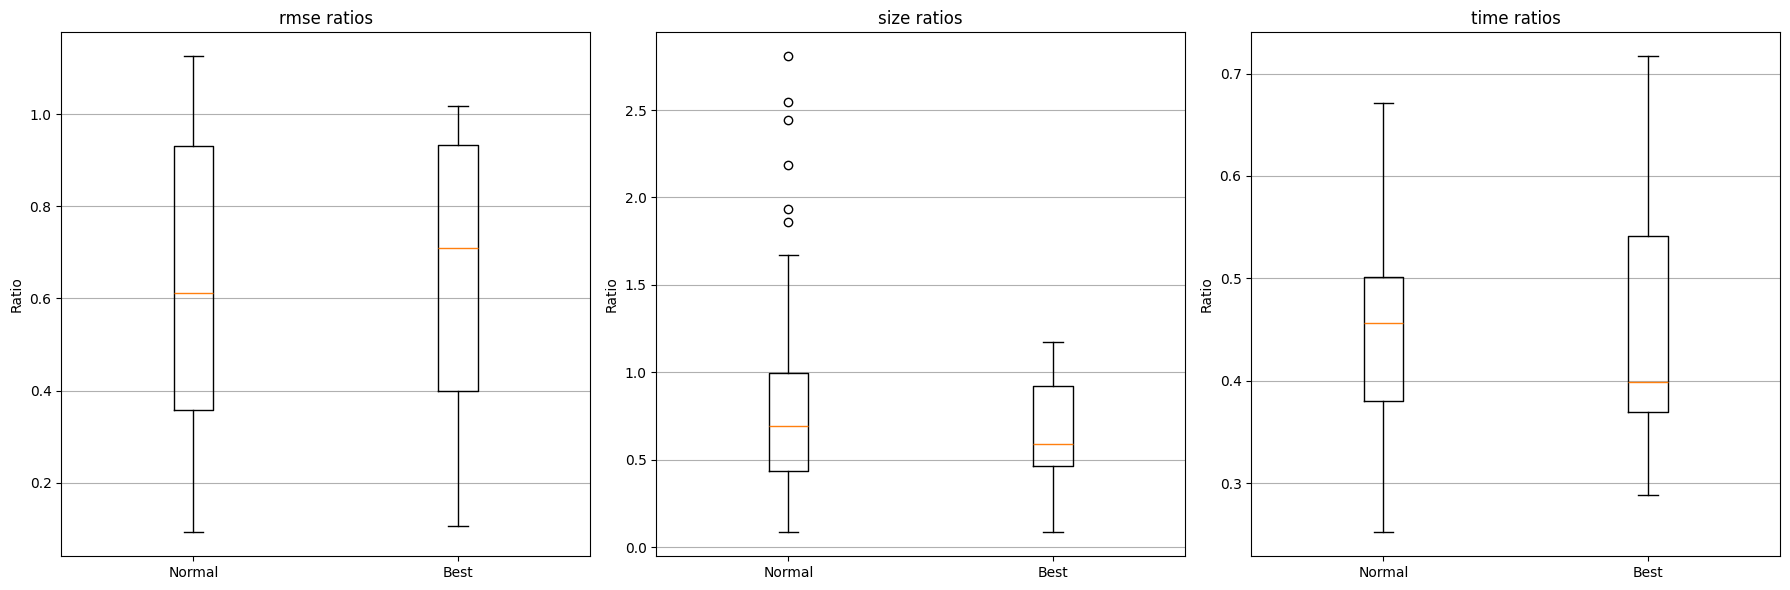

In [84]:
summary_results(
    prefixes=['sc_11', 'un_11'],
    metrics=metrics,
    datasets=None
)

                        All Significance Counts and Ratios                                                  Best Significance Counts and Ratios                       
+----------+----------+----------+----------+----------------+--------------+        +----------+-----+---------+---------+----------+----------------+--------------+
| Metric   | +        | -        | NSD      |   Median Ratio |   Mean Ratio |        | Metric   |   ! | +       | -       | NSD      |   Median Ratio |   Mean Ratio |
+==========+==========+==========+==========+================+==============+        +==========+=====+=========+=========+==========+================+==============+
| rmse     | 31 (34%) | 10 (11%) | 49 (54%) |          0.987 |     0.952889 |        | rmse     |   1 | 3 (21%) | 0 (0%)  | 11 (78%) |          0.992 |      0.9378  |
+----------+----------+----------+----------+----------------+--------------+        +----------+-----+---------+---------+----------+----------------+--------------

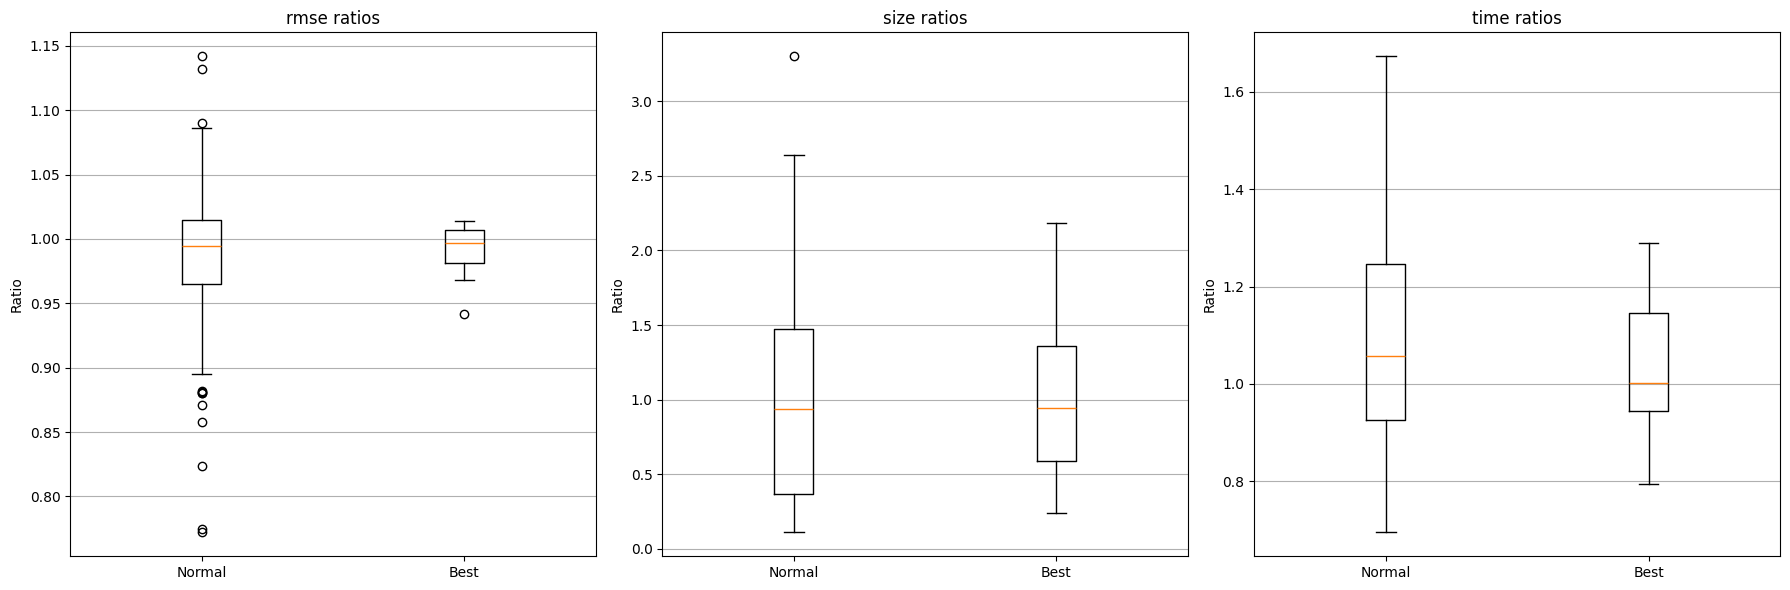

In [85]:
summary_results(
    prefixes=["scsm_11", "sc_11"],
    metrics=metrics,
    datasets=None,
)

                      All Significance Counts and Ratios                                               Best Significance Counts and Ratios                      
+----------+----------+-----------+----------+----------------+--------------+    +----------+---------+-----------+---------+----------------+--------------+
| Metric   | +        | -         | NSD      |   Median Ratio |   Mean Ratio |    | Metric   | +       | -         | NSD     |   Median Ratio |   Mean Ratio |
+==========+==========+===========+==========+================+==============+    +==========+=========+===========+=========+================+==============+
| rmse     | 22 (24%) | 45 (50%)  | 23 (25%) |         1.029  |      1.11764 |    | rmse     | 2 (13%) | 6 (40%)   | 7 (46%) |          1.027 |      1.03413 |
+----------+----------+-----------+----------+----------------+--------------+    +----------+---------+-----------+---------+----------------+--------------+
| size     | 40 (44%) | 46 (51%)  | 4 (4%)  

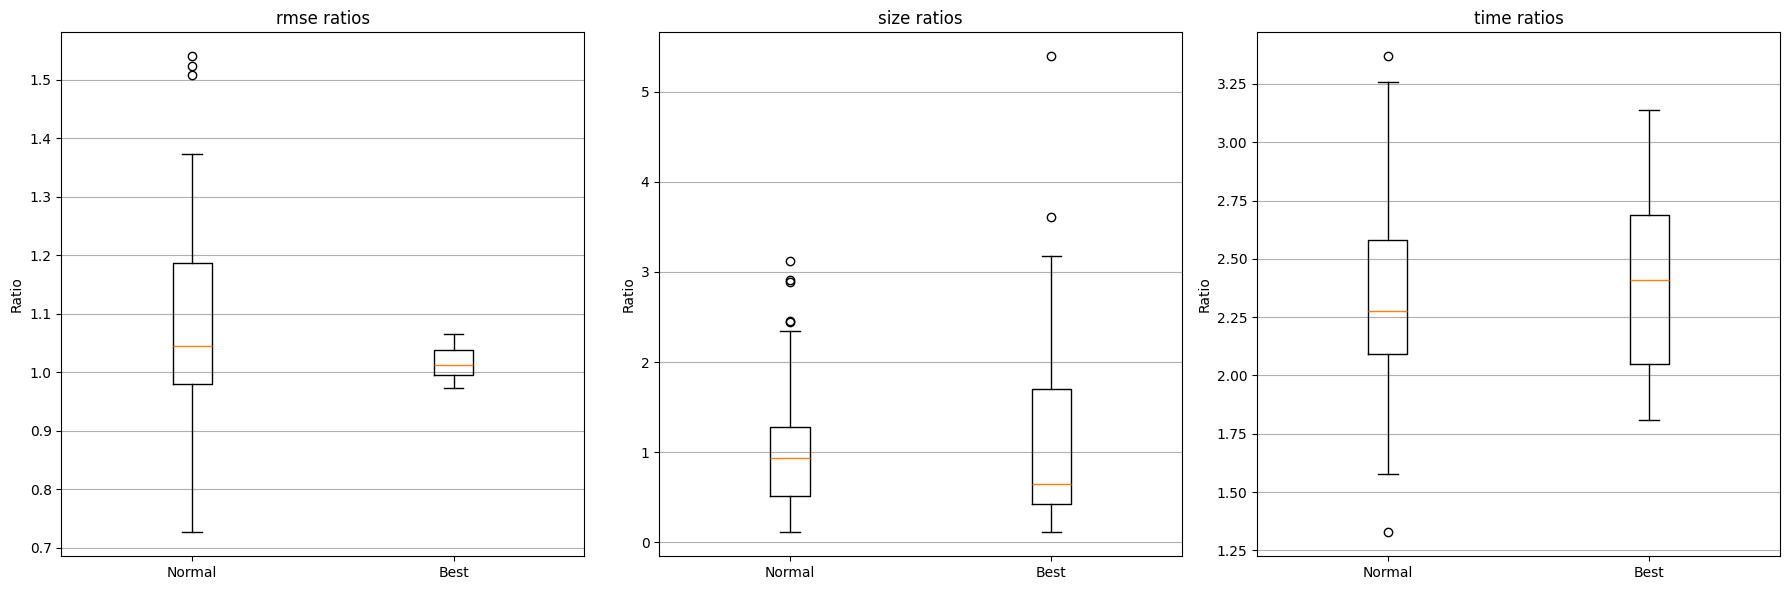

In [86]:
summary_results(
    prefixes=["unsm_11", "scsm_11"],
    metrics=metrics,
    datasets=None,
)

In [56]:
with open('params/DA14/unsmsp_11.pkl', 'rb') as f:
    params = pickle.load(f)

params['MUL_ABS']['nodes']

array([120.75,  99.  , 145.  , 217.75,  36.75, 166.75,  60.25, 102.5 ,
       158.5 , 178.  , 241.75, 114.5 , 129.5 , 200.75, 149.25, 154.25,
        40.5 ,  79.75, 112.75,  96.75,  54.25, 133.  , 176.75,  42.  ,
        55.25, 104.75,  59.5 ,  48.5 , 228.75, 100.25,  92.5 , 299.5 ,
       141.5 ,  25.5 , 228.5 , 207.75, 178.  ,  41.5 ,  56.5 , 160.75,
        91.25, 111.  , 122.25,  52.5 ,  83.5 ])

In [799]:
stds_un, stds_unsm = [], []
for i in range(15):
    i = str(i)
    if len(i) < 2:
        i = i.zfill(2)
    
    with open(f'params/DA{i}/un_10.pkl', 'rb') as f:
        params_un = pickle.load(f)
    with open(f'params/DA{i}/unsm_10.pkl', 'rb') as f:
        params_unsm = pickle.load(f)
    temp_un, temp_unsm = [], []
    for algo in params_un.keys():
        temp_un += list(params_un[algo]['scores'])
        temp_unsm += list(params_unsm[algo]['scores'])
    
    temp_un = np.array(temp_un)
    temp_unsm = np.array(temp_unsm)
    stds_un.append(np.std(temp_un, axis=0)/np.mean(temp_un, axis=0)) if np.mean(temp_un, axis=0) != 0 else stds_un.append(np.std(temp_un, axis=0))
    stds_unsm.append(np.std(temp_unsm, axis=0)/np.mean(temp_unsm, axis=0)) if np.mean(temp_unsm, axis=0) != 0 else stds_unsm.append(np.std(temp_unsm, axis=0))

print('Un standard deviations:', np.mean(stds_un, axis=0))
print('Unsm standard deviations:', np.mean(stds_unsm, axis=0))

Un standard deviations: 0.21242777
Unsm standard deviations: 0.25657824


In [58]:
def analyze_variability(instruments, datasets, params_path="params"):
    """
    Analyze the variability of scores for selected instruments and datasets.

    Parameters:
    ----------
    instruments : list of str
        Names of the instruments (e.g., ['un_10', 'unsm_10']).
    datasets : list of int
        List of dataset indices to analyze.
    params_path : str
        Path to the parameter files.

    Returns:
    -------
    dataset_variability : pd.DataFrame
        Table showing variability (mean ± std) grouped by dataset.
    algorithm_variability : pd.DataFrame
        Table showing variability (mean ± std) grouped by algorithm.
    """
    dataset_variability = []
    algorithm_variability = {}

    for dataset_idx in datasets:
        dataset_idx = str(dataset_idx).zfill(2)
        dataset_scores = {instrument: [] for instrument in instruments}

        for instrument in instruments:
            try:
                with open(f"{params_path}/DA{dataset_idx}/{instrument}.pkl", "rb") as f:
                    params = pickle.load(f)
                for algo, algo_data in params.items():
                    scores = np.array(algo_data["scores"])
                    dataset_scores[instrument].append(scores)
                    
                    # Aggregate scores by algorithm
                    if algo not in algorithm_variability:
                        algorithm_variability[algo] = {instr: [] for instr in instruments}
                    algorithm_variability[algo][instrument].append(scores)
            except FileNotFoundError:
                print(f"Warning: File {params_path}/DA{dataset_idx}/{instrument}.pkl not found.")
                continue

        # Compute variability by dataset
        dataset_row = {"dataset": dataset_idx}
        for instrument, scores_list in dataset_scores.items():
            scores_array = np.concatenate(scores_list) if scores_list else np.array([])
            if scores_array.size > 0:
                mean_score = np.mean(scores_array)
                std_score = np.std(scores_array)
                variability = f"{mean_score:.2f} ± {std_score:.2f}"
            else:
                variability = "N/A"
            dataset_row[instrument] = variability
        dataset_variability.append(dataset_row)

    # Compute variability by algorithm
    algo_table = []
    for algo, instrument_scores in algorithm_variability.items():
        algo_row = {"algorithm": algo}
        for instrument, scores_list in instrument_scores.items():
            scores_array = np.concatenate(scores_list) if scores_list else np.array([])
            if scores_array.size > 0:
                mean_score = np.mean(scores_array)
                std_score = np.std(scores_array)
                variability = f"{mean_score:.2f} ± {std_score:.2f}"
            else:
                variability = "N/A"
            algo_row[instrument] = variability
        algo_table.append(algo_row)

    # Convert to DataFrame
    dataset_variability_df = pd.DataFrame(dataset_variability)
    algorithm_variability_df = pd.DataFrame(algo_table)

    return dataset_variability_df, algorithm_variability_df


# Example usage
instruments = ['sc_10', 'scsm_10']
datasets = range(15)

dataset_variability, algorithm_variability = analyze_variability(instruments, datasets)

# Display the tables
print("Dataset Variability:")
print(dataset_variability)

print("\nAlgorithm Variability:")
print(algorithm_variability)

Dataset Variability:
   dataset         sc_10      scsm_10
0       00   0.06 ± 0.02  0.03 ± 0.00
1       01   0.09 ± 0.01  0.09 ± 0.01
2       02   0.15 ± 0.05  0.13 ± 0.02
3       03   0.07 ± 0.04  0.04 ± 0.03
4       04   0.13 ± 0.02  0.12 ± 0.03
5       05   0.27 ± 0.04  0.26 ± 0.05
6       06   0.28 ± 0.02  0.28 ± 0.02
7       07   0.13 ± 0.02  0.13 ± 0.02
8       08   0.19 ± 0.01  0.18 ± 0.01
9       09   0.11 ± 0.05  0.08 ± 0.02
10      10   0.11 ± 0.04  0.09 ± 0.02
11      11   0.22 ± 0.02  0.21 ± 0.01
12      12   0.24 ± 0.01  0.25 ± 0.04
13      13  4.26 ± 19.75  0.30 ± 0.03
14      14   0.29 ± 0.00  0.29 ± 0.01

Algorithm Variability:
  algorithm         sc_10      scsm_10
0   MUL_ABS   0.16 ± 0.08  0.18 ± 0.09
1  MUL_SIG1  1.32 ± 10.78  0.17 ± 0.09
2  MUL_SIG2   0.18 ± 0.08  0.14 ± 0.09
3   SUM_ABS   0.16 ± 0.08  0.16 ± 0.09
4  SUM_SIG1   0.15 ± 0.08  0.16 ± 0.08
5  SUM_SIG2   0.16 ± 0.09  0.15 ± 0.09


In [ ]:
def analyze_variability_with_size(instruments, params_path="params"):
    """
    Analyze the variability of scores and sizes for selected instruments and datasets.

    Parameters:
    ----------
    instruments : list of str
        Names of the instruments (e.g., ['un_10', 'unsm_10']).
    datasets : list of int
        List of dataset indices to analyze.
    params_path : str
        Path to the parameter files.
    """
    dataset_variability = []
    algorithm_variability = {}
    dataset_sizes = []
    algorithm_sizes = {}
    datasets = range(15)

    for dataset_idx in datasets:
        dataset_idx = str(dataset_idx).zfill(2)
        dataset_scores = {instrument: [] for instrument in instruments}
        dataset_node_sizes = {instrument: [] for instrument in instruments}

        for instrument in instruments:
            try:
                with open(f"{params_path}/DA{dataset_idx}/{instrument}.pkl", "rb") as f:
                    params = pickle.load(f)
                for algo, algo_data in params.items():
                    scores = np.array(algo_data["scores"])
                    sizes = np.array(algo_data["nodes"])  # Assuming "sizes" contains node sizes
                    dataset_scores[instrument].append(scores)
                    dataset_node_sizes[instrument].append(sizes)

                    # Aggregate scores and sizes by algorithm
                    if algo not in algorithm_variability:
                        algorithm_variability[algo] = {instr: [] for instr in instruments}
                        algorithm_sizes[algo] = {instr: [] for instr in instruments}

                    algorithm_variability[algo][instrument].append(scores)
                    algorithm_sizes[algo][instrument].append(sizes)
            except FileNotFoundError:
                print(f"Warning: File {params_path}/DA{dataset_idx}/{instrument}.pkl not found.")
                continue

        # Compute variability and size by dataset
        dataset_row = {"dataset": dataset_idx}
        size_row = {"dataset": dataset_idx}

        for instrument, scores_list in dataset_scores.items():
            scores_array = np.concatenate(scores_list) if scores_list else np.array([])
            sizes_array = np.concatenate(dataset_node_sizes[instrument]) if dataset_node_sizes[instrument] else np.array([])

            if scores_array.size > 0:
                mean_score = np.mean(scores_array)
                std_score = np.std(scores_array)
                variability = f"{mean_score:.2f} ± {std_score:.2f}"
            else:
                variability = "N/A"

            if sizes_array.size > 0:
                mean_size = np.mean(sizes_array)
                size = f"{mean_size:.2f}"
            else:
                size = "N/A"

            dataset_row[instrument] = variability
            size_row[instrument] = size

        dataset_variability.append(dataset_row)
        dataset_sizes.append(size_row)

    # Compute variability and size by algorithm
    algo_table = []
    algo_size_table = []

    for algo, instrument_scores in algorithm_variability.items():
        algo_row = {"algorithm": algo}
        size_row = {"algorithm": algo}

        for instrument, scores_list in instrument_scores.items():
            scores_array = np.concatenate(scores_list) if scores_list else np.array([])
            sizes_array = np.concatenate(algorithm_sizes[algo][instrument]) if algorithm_sizes[algo][instrument] else np.array([])

            if scores_array.size > 0:
                mean_score = np.mean(scores_array)
                std_score = np.std(scores_array)
                variability = f"{mean_score:.2f} ± {std_score:.2f}"
            else:
                variability = "N/A"

            if sizes_array.size > 0:
                mean_size = np.mean(sizes_array)
                size = f"{mean_size:.2f}"
            else:
                size = "N/A"

            algo_row[instrument] = variability
            size_row[instrument] = size

        algo_table.append(algo_row)
        algo_size_table.append(size_row)

    # Convert to DataFrame
    dataset_variability_df = pd.DataFrame(dataset_variability).set_index("dataset")
    algorithm_variability_df = pd.DataFrame(algo_table).set_index("algorithm")
    dataset_sizes_df = pd.DataFrame(dataset_sizes).set_index("dataset")
    algorithm_sizes_df = pd.DataFrame(algo_size_table).set_index("algorithm")

    # Print the tables
    print("\nDataset Variability:")
    print(dataset_variability_df.to_string())

    print("\nAlgorithm Variability:")
    print(algorithm_variability_df.to_string())

    print("\nDataset Sizes:")
    print(dataset_sizes_df.to_string())

    print("\nAlgorithm Sizes:")
    print(algorithm_sizes_df.to_string())


# Example usage
instruments = ['unsm_11', 'un_11']
analyze_variability_with_size(instruments)


Dataset Variability:
                  unsm_11            un_11
dataset                                   
00          40.74 ± 25.28   105.44 ± 31.45
01            0.01 ± 0.00      0.01 ± 0.00
02          23.97 ± 17.06    32.83 ± 13.47
03            0.00 ± 0.00  304.52 ± 423.62
04            5.57 ± 1.18      7.53 ± 1.63
05            0.27 ± 0.05      0.28 ± 0.05
06            8.54 ± 1.32     10.23 ± 1.98
07           11.79 ± 5.92     20.67 ± 8.82
08          93.06 ± 42.53   144.68 ± 28.20
09            3.15 ± 0.76      5.91 ± 3.35
10            4.70 ± 3.45      5.26 ± 2.91
11            1.57 ± 0.58      1.43 ± 0.01
12       2096.69 ± 108.68  2203.95 ± 76.03
13           30.73 ± 2.73     32.63 ± 3.24
14          38.34 ± 11.77     44.61 ± 8.47

Algorithm Variability:
                   unsm_11            un_11
algorithm                                  
MUL_ABS     70.81 ± 348.02  179.17 ± 552.73
MUL_SIG1   100.79 ± 405.90   91.64 ± 337.22
MUL_SIG2   116.94 ± 450.37  117.21 ± 427.42
SUM

In [73]:
df_stats_ = df_stats.reset_index()
df_stats_ = df_stats_.set_index('Dataset')

df1 = pd.concat([df_stats_, df['ratio_rmse']], axis=1).drop('index', axis=1)
df1_ = df1.drop(['bike_sharing', 'diabetes'], axis=0)
df1_ = df1
df1_.corr()

,n,k,ratio_means,ratio_stds,sum_ratio,mean(y),std(y),mean(X),std(X),ratio_rmse
n,1.000000,-0.508865,0.092294,-0.027438,-0.092072,0.031479,-0.119803,-0.148708,-0.151994,0.071336
k,-0.508865,1.000000,0.067470,0.306124,-0.059260,0.106060,0.399717,-0.009781,-0.012995,0.084845
ratio_means,0.092294,0.067470,1.000000,-0.284353,-0.850538,0.061852,0.059445,0.195625,0.193029,-0.010987
ratio_stds,-0.027438,0.306124,-0.284353,1.000000,0.644438,-0.074287,0.227904,0.377764,0.373578,0.326777
sum_ratio,-0.092072,-0.059260,-0.850538,0.644438,1.000000,-0.092945,-0.006055,0.195600,0.196537,0.108377
mean(y),0.031479,0.106060,0.061852,-0.074287,-0.092945,1.000000,0.883153,-0.048176,-0.050565,-0.912179
std(y),-0.119803,0.399717,0.059445,0.227904,-0.006055,0.883153,1.000000,-0.043973,-0.048503,-0.663139
mean(X),-0.148708,-0.009781,0.195625,0.377764,0.195600,-0.048176,-0.043973,1.000000,0.999950,0.049936
std(X),-0.151994,-0.012995,0.193029,0.373578,0.196537,-0.050565,-0.048503,0.999950,1.000000,0.048864
ratio_rmse,0.071336,0.084845,-0.010987,0.326777,0.108377,-0.912179,-0.663139,0.049936,0.048864,1.000000


In [460]:
df_stats

,Dataset,n,k,ratio_means,ratio_stds,sum_ratio,mean(y),std(y),mean(X),std(X)
DA08,diabetes,442,10,-12.3076,3.2092,15.5169,152.1335,77.0057,-0.0000,0.0476
DA00,resid_build_sale_price,372,107,2.5117,3.4936,6.0052,232.6478,162.4089,75571.8984,506050.5000
DA12,ld50,234,626,0.4360,4.4403,4.8763,1672.7267,2019.4557,612.9604,0.0733
DA05,breast_cancer,569,30,2.0729,1.4280,3.5010,0.6274,0.4835,74.2164,0.0180
DA02,airfoil,1503,5,0.6737,2.7198,3.3935,124.8359,6.8964,588.8343,0.0131
DA09,efficiency_heating,768,8,0.9427,1.8793,2.8221,22.3072,10.0836,195.5102,0.1331
DA10,efficiency_cooling,768,8,0.9005,1.8538,2.7542,24.5878,9.5071,195.5102,0.1331
DA14,bioav,358,241,0.0587,2.4212,2.4799,66.3662,30.4992,57.9756,0.1156
DA11,forest_fires,513,43,1.4344,1.0268,2.4612,1.1131,1.3963,0.0409,0.1313
DA06,concrete_slump,103,7,1.2576,0.8596,2.1172,18.0485,8.7083,326.5963,63.0339


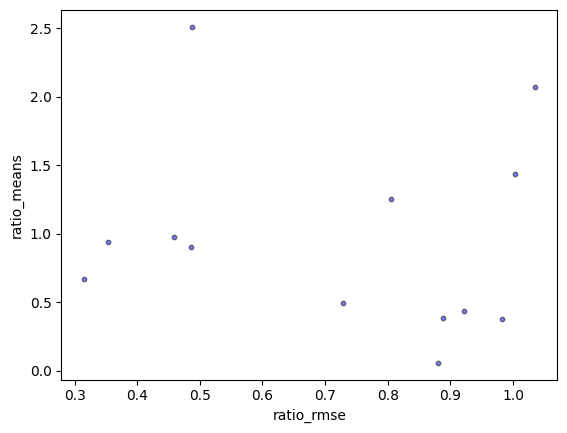

In [490]:
# Scatterplot of the columns of the DataFrame against the ratio_rmse
df1_ = df1.drop(['bike_sharing','airfoil', 'diabetes'], axis=0)
# df1_ = df1
instrument = 'ratio_means'
plt.scatter(df1_['ratio_rmse'], df1_[instrument], c='blue', alpha=0.5, label='ratio_stds', s=10, edgecolors='k', marker='o')
plt.xlabel('ratio_rmse')
plt.ylabel(instrument)
plt.show()

UNSM vs UN 
+ discrepancia entre as escalas das variáveis vs a variável target => que SM ajuda
+ n => que SM ajuda
+ k => que SM nao ajuda tanto 

UNSM vs SCSM 
+ ratio_stds => o scaling ajuda mais 

SCSM vs SC 
+ n => melhor performance 

In [ ]:
import statsmodels.api as sm
df1_ = df1.drop(['airfoil', 'bike_sharing', 'ld50'], axis=0)
X = df1_.drop(['ratio_rmse',
              #'mean(y)', 
              'mean(X)', 
              'std(y)', 
              'std(X)', 
              'k', 
              'sum_ratio', 
              'ratio_means', 
              # 'n', 
              'ratio_stds'
              ], axis=1)  
y = df1_['ratio_rmse']

X = sm.add_constant(X)
model = sm.GLS(y, X).fit()
predictions = model.predict(X)

print_model = model.summary()
print(print_model)

                            GLS Regression Results                            
Dep. Variable:             ratio_rmse   R-squared:                       0.581
Model:                            GLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     6.231
Date:                Tue, 07 Jan 2025   Prob (F-statistic):             0.0200
Time:                        21:59:02   Log-Likelihood:                 5.0654
No. Observations:                  12   AIC:                            -4.131
Df Residuals:                       9   BIC:                            -2.676
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1453      0.141      8.113      0.0

c:\Users\Mateus\Documents\Tese\Codigo\SLIM-TEST-LITE\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  res = hypotest_fun_out(*samples, **kwds)


In [100]:
dataset_dict

{'resid_build_sale_price': 'DA00',
 'istanbul': 'DA01',
 'airfoil': 'DA02',
 'bike_sharing': 'DA03',
 'boston': 'DA04',
 'breast_cancer': 'DA05',
 'concrete_slump': 'DA06',
 'concrete_strength': 'DA07',
 'diabetes': 'DA08',
 'efficiency_heating': 'DA09',
 'efficiency_cooling': 'DA10',
 'forest_fires': 'DA11',
 'ld50': 'DA12',
 'ppb': 'DA13',
 'bioav': 'DA14'}

In [11]:
with open('params/DA02/scsm_5.pkl', 'rb') as f:
    params_5 = pickle.load(f)['MUL_ABS']

with open('params/DA02/scsm_8.pkl', 'rb') as f:
    params_8 = pickle.load(f)['MUL_ABS']

In [52]:
datasets

[<function slim_gsgp_lib.datasets.data_loader.load_resid_build_sale_price(X_y=True)>,
 <function slim_gsgp_lib.datasets.data_loader.load_istanbul(X_y=True)>,
 <function slim_gsgp_lib.datasets.data_loader.load_airfoil(X_y=True)>,
 <function slim_gsgp_lib.datasets.data_loader.load_bike_sharing(X_y=True)>,
 <function slim_gsgp_lib.datasets.data_loader.load_boston(X_y=True)>,
 <function slim_gsgp_lib.datasets.data_loader.load_breast_cancer(X_y=True)>,
 <function slim_gsgp_lib.datasets.data_loader.load_concrete_slump(X_y=True)>,
 <function slim_gsgp_lib.datasets.data_loader.load_concrete_strength(X_y=True)>,
 <function slim_gsgp_lib.datasets.data_loader.load_diabetes(X_y=True)>,
 <function slim_gsgp_lib.datasets.data_loader.load_efficiency_heating(X_y=True)>,
 <function slim_gsgp_lib.datasets.data_loader.load_efficiency_cooling(X_y=True)>,
 <function slim_gsgp_lib.datasets.data_loader.load_forest_fires(X_y=True)>,
 <function slim_gsgp_lib.datasets.data_loader.load_ld50(X_y=True)>,
 <functio

In [95]:
means_df(prefixes=['unsm_10', 'scsm_10'],
         best=True, rmse_compare=True, decimals=4, table=True)

╒════════════════════════╤═════════════════════╤═════════════════════╤══════════════╤═════════════════════╤══════════════════╤══════════════════╤══════════════╤═════════════════════╤═══════════════════╤═══════════════════╤══════════════╤═════════════════════╕
│                        │ rmse_unsm_10        │ rmse_scsm_10        │   ratio_rmse │ rmse_significance   │ size_unsm_10     │ size_scsm_10     │   ratio_size │ size_significance   │ time_unsm_10      │ time_scsm_10      │   ratio_time │ time_significance   │
╞════════════════════════╪═════════════════════╪═════════════════════╪══════════════╪═════════════════════╪══════════════════╪══════════════════╪══════════════╪═════════════════════╪═══════════════════╪═══════════════════╪══════════════╪═════════════════════╡
│ bike_sharing           │ 0.0 ± 0.0           │ 154.7455 ± 95.3725  │       0.0000 │ +                   │ 4.32 ± 1.8595    │ 61.86 ± 17.0235  │       0.0698 │ +                   │ 71.3716 ± 10.7618 │ 49.0996 ± 19.9796

In [14]:
means_df(prefixes=['scsp_9', 'scsp_5'],
         best=True, rmse_compare=False, decimals=4, table=True)

╒════════════════════════╤═════════════════╤═════════════════╤══════════════╤═════════════════════╤══════════════════╤══════════════════╤══════════════╤═════════════════════╕
│                        │ rmse_scsp_9     │ rmse_scsp_5     │   ratio_rmse │ rmse_significance   │ size_scsp_9      │ size_scsp_5      │   ratio_size │ size_significance   │
╞════════════════════════╪═════════════════╪═════════════════╪══════════════╪═════════════════════╪══════════════════╪══════════════════╪══════════════╪═════════════════════╡
│ bike_sharing           │ 0.0276 ± 0.0191 │ 0.0374 ± 0.024  │       0.7360 │ +                   │ 112.14 ± 25.9014 │ 115.66 ± 24.3767 │       0.9696 │ NSD                 │
├────────────────────────┼─────────────────┼─────────────────┼──────────────┼─────────────────────┼──────────────────┼──────────────────┼──────────────┼─────────────────────┤
│ boston                 │ 0.1128 ± 0.0157 │ 0.143 ± 0.0197  │       0.7893 │ +                   │ 215.9 ± 31.2508  │ 167.26

In [57]:
means_df(prefixes=['scsp_9', 'scsp_5'],
         best=False, rmse_compare=False, decimals=4, table=False).describe()

,rmse_scsp_9,rmse_scsp_5,size_scsp_9,size_scsp_5,ratio_rmse,ratio_size,rmse_std_scsp_9,rmse_std_scsp_5,size_std_scsp_9,size_std_scsp_5
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,0.167656,0.177004,102.094889,76.147556,0.940956,2.003758,0.014374,0.040603,24.958028,14.200122
std,0.092942,0.095868,50.751672,47.310724,0.188341,2.175517,0.008858,0.112648,9.364837,8.891564
min,0.027600,0.037400,13.760000,12.000000,0.328900,0.175900,0.001600,0.003300,4.769200,1.496700
25%,0.092050,0.084550,71.205000,35.790000,0.856725,0.919625,0.007050,0.008625,18.843750,6.462550
50%,0.134650,0.153950,100.740000,76.590000,0.945050,1.342850,0.012350,0.017600,25.048500,13.481900
75%,0.251575,0.244100,137.585000,100.995000,1.073500,1.931175,0.021525,0.026675,31.962875,20.776000
max,0.351600,0.376800,218.900000,236.660000,1.281200,12.528400,0.036200,0.960600,48.100500,41.161400


In [38]:
means_df(prefixes=['sc_9', 'scsm_7'],
         best=True, rmse_compare=True, decimals=4, table=False).value_counts('rmse_significance')

rmse_significance
NSD    10
+       3
-       2
Name: count, dtype: int64

In [70]:
means_df(prefixes=['scsm_8', 'sc_7'],
         best=True, rmse_compare=False, decimals=4, table=True)

╒════════════════════════╤═════════════════╤═════════════════╤══════════════╤═════════════════════╤══════════════════╤══════════════════╤══════════════╤═════════════════════╕
│                        │ rmse_scsm_8     │ rmse_sc_7       │   ratio_rmse │ rmse_significance   │ size_scsm_8      │ size_sc_7        │   ratio_size │ size_significance   │
╞════════════════════════╪═════════════════╪═════════════════╪══════════════╪═════════════════════╪══════════════════╪══════════════════╪══════════════╪═════════════════════╡
│ bike_sharing           │ 0.0164 ± 0.0122 │ 0.0384 ± 0.0204 │       0.4265 │ +                   │ 129.65 ± 53.4165 │ 98.86 ± 13.6191  │       1.3115 │ -                   │
├────────────────────────┼─────────────────┼─────────────────┼──────────────┼─────────────────────┼──────────────────┼──────────────────┼──────────────┼─────────────────────┤
│ resid_build_sale_price │ 0.0431 ± 0.0152 │ 0.0548 ± 0.0246 │       0.7859 │ +                   │ 92.98 ± 24.8371  │ 147.91

In [32]:
means_df(prefixes=['scsm_7', 'sc_7'],
         best=True, rmse_compare=False, decimals=4, table=False)

Error in significance test: zero_method 'wilcox' and 'pratt' do not work if x - y is zero for all elements., ld50, SUM_SIG2, sc_7


,rmse_scsm_7,rmse_sc_7,ratio_rmse,rmse_significance,size_scsm_7,size_sc_7,ratio_size,size_significance
bike_sharing,0.0182,0.0384,0.4750,+++,91.46,98.86,0.9251,NSD
resid_build_sale_price,0.0463,0.0548,0.8441,+++,63.08,147.91,0.4265,+++
ppb,0.3174,0.3559,0.8920,NSD,140.94,255.49,0.5516,+++
concrete_strength,0.1033,0.1118,0.9247,+++,218.58,139.42,1.5678,---
efficiency_heating,0.0586,0.0623,0.9408,++,177.87,150.25,1.1838,---
breast_cancer,0.2579,0.2714,0.9501,+++,109.61,134.29,0.8162,+++
airfoil,0.1255,0.1316,0.9535,+++,162.09,119.65,1.3547,---
efficiency_cooling,0.0784,0.0818,0.9588,+,137.84,143.08,0.9634,+
boston,0.1149,0.1187,0.9684,NSD,104.39,73.72,1.4160,---
diabetes,0.1934,0.1950,0.9919,+,139.99,100.02,1.3996,---


In [69]:
means_df(prefixes=['scsmsp_7', 'sc_7'],
         best=True, rmse_compare=False, decimals=4, table=False)

,rmse_scsmsp_7,rmse_sc_7,ratio_rmse,rmse_significance,size_scsmsp_7,size_sc_7,ratio_size,size_significance
bike_sharing,0.0160,0.0384,0.4167,+++,62.67,98.86,0.6339,+++
resid_build_sale_price,0.0438,0.0548,0.7981,+++,45.40,147.91,0.3069,+++
ppb,0.3128,0.3559,0.8790,NSD,93.10,255.49,0.3644,+++
efficiency_cooling,0.0745,0.0818,0.9111,+++,174.85,143.08,1.2220,---
concrete_strength,0.1029,0.1118,0.9210,+++,203.80,139.42,1.4618,---
airfoil,0.1244,0.1316,0.9457,+++,144.98,119.65,1.2117,---
breast_cancer,0.2577,0.2714,0.9497,+++,114.66,134.29,0.8538,+++
boston,0.1158,0.1187,0.9760,NSD,72.94,73.72,0.9894,NSD
forest_fires,0.2140,0.2137,1.0015,-,23.47,17.26,1.3598,---
istanbul,0.0986,0.0985,1.0016,NSD,53.95,72.45,0.7447,+++


In [65]:
means_df(prefixes=['scsm_5', 'sc_5'],
         best=True, rmse_compare=False, decimals=4, table=False)

,rmse_scsm_5,rmse_sc_5,ratio_rmse,rmse_significance,size_scsm_5,size_sc_5,ratio_size,size_significance
bike_sharing,0.0166,0.0368,0.4513,+++,109.30,61.96,1.7640,---
resid_build_sale_price,0.0495,0.0653,0.7579,+++,74.26,112.88,0.6579,+++
efficiency_heating,0.0603,0.0736,0.8192,+++,235.60,86.04,2.7383,---
efficiency_cooling,0.0671,0.0764,0.8781,+++,196.12,146.10,1.3424,---
concrete_strength,0.1093,0.1203,0.9085,+++,179.22,86.68,2.0676,---
boston,0.1355,0.1485,0.9123,+++,148.68,109.92,1.3526,---
breast_cancer,0.2160,0.2257,0.9569,+,126.26,101.52,1.2437,---
concrete_slump,0.2581,0.2695,0.9575,NSD,72.86,100.26,0.7267,+++
bioav,0.3257,0.3356,0.9705,NSD,76.50,18.00,4.2500,---
ld50,0.2371,0.2406,0.9853,NSD,28.36,49.94,0.5679,+++


In [39]:
means_df(prefixes=['scsmsp_5', 'scsm_5'],
         best=False, rmse_compare=False, decimals=4, table=False).loc['resid_build_sale_price']

,rmse_scsmsp_5,rmse_scsm_5,size_scsmsp_5,size_scsm_5,ratio_rmse,ratio_size,rmse_significance,size_significance
Algorithm,,,,,,,,
SUM_SIG1,0.0464,0.0578,94.58,77.12,0.8020,1.2264,+,---
SUM_SIG2,0.0539,0.0577,74.92,136.50,0.9347,0.5489,NSD,+++
MUL_SIG2,0.0543,0.0578,103.40,181.40,0.9396,0.5700,NSD,+++
MUL_ABS,0.0486,0.0495,49.98,74.26,0.9819,0.6730,NSD,+++
MUL_SIG1,0.0547,0.0496,80.54,68.92,1.1045,1.1686,NSD,---
SUM_ABS,0.0654,0.0578,128.02,145.62,1.1321,0.8791,NSD,NSD


In [71]:
results1.keys()

dict_keys(['rmse', 'mape', 'mae', 'rmse_compare', 'mape_compare', 'mae_compare', 'time', 'train_fit', 'test_fit', 'size', 'representations'])

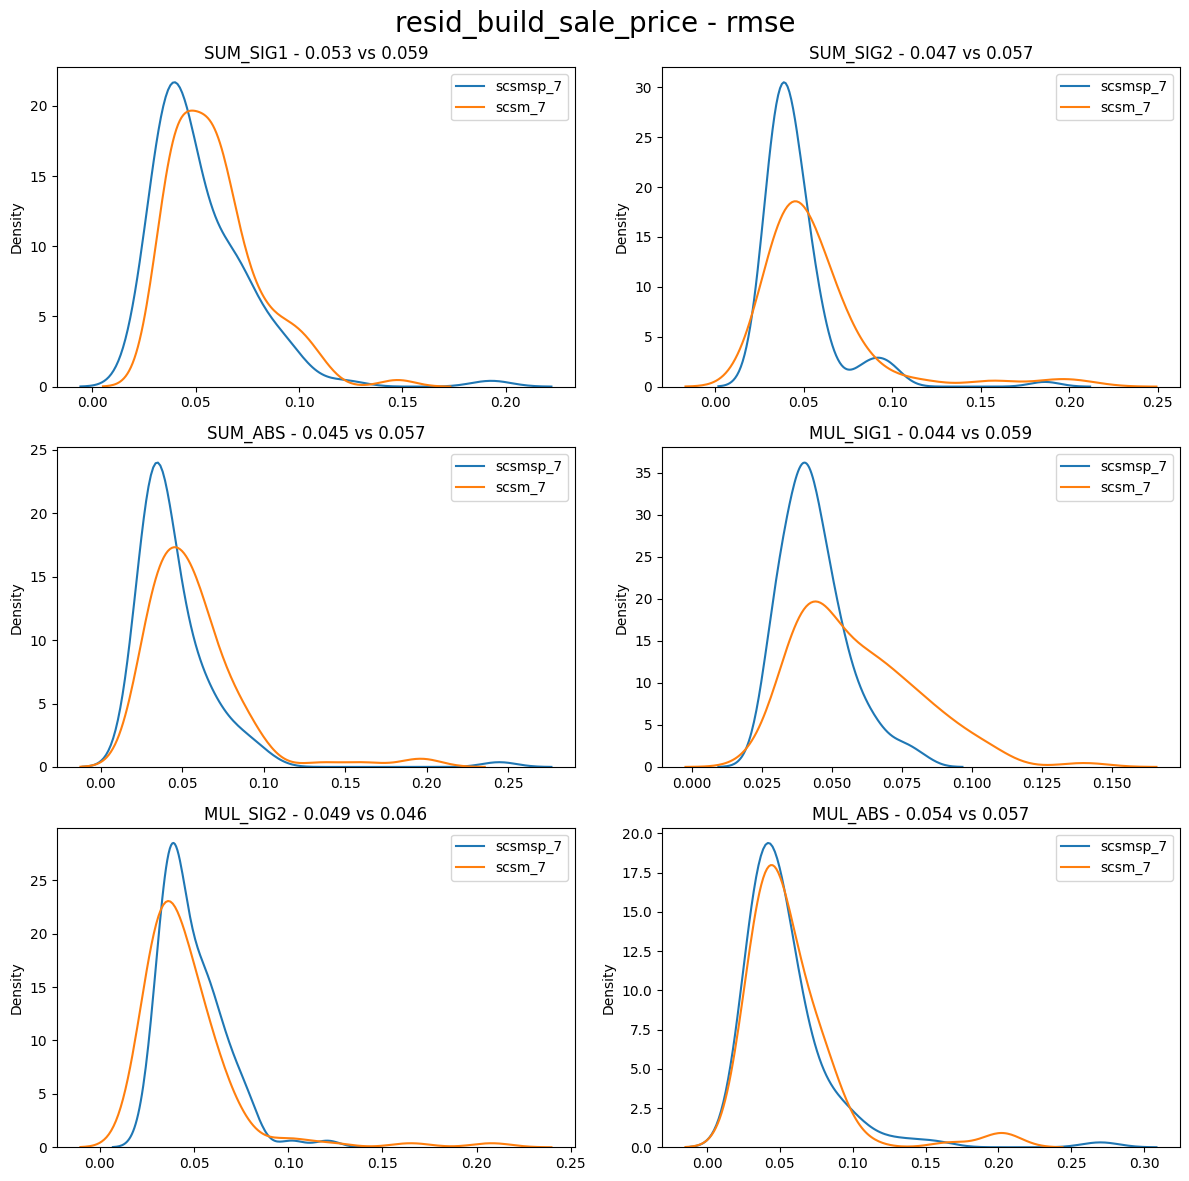

In [67]:
prefixes = ['scsmsp_7', 'scsm_7']
dataset = 'resid_build_sale_price'
dataset_id = dataset_dict[dataset]

with open(f'results/slim/{dataset_id}/{prefixes[0]}.pkl', 'rb') as f:
    results1 = pickle.load(f)

with open(f'results/slim/{dataset_id}/{prefixes[1]}.pkl', 'rb') as f:
    results2 = pickle.load(f)

algorithms = ['SUM_SIG1', 'SUM_SIG2', 'SUM_ABS', 'MUL_SIG1', 'MUL_SIG2', 'MUL_ABS']

# For each algorithm, plot the RMSE distribution for the two variants 
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
axs = axs.flatten()

for i, algo in enumerate(algorithms):
    sns.kdeplot(results1['rmse'][algo], ax=axs[i], label=prefixes[0])
    sns.kdeplot(results2['rmse'][algo], ax=axs[i], label=prefixes[1])    
    axs[i].set_title(f'{algo} - {np.mean(results1['rmse'][algo]):.3f} vs {np.mean(results2['rmse'][algo]):.3f}')
    axs[i].legend()

fig.suptitle(f'{dataset} - {'rmse'}', fontsize=20)
plt.tight_layout()
plt.show()

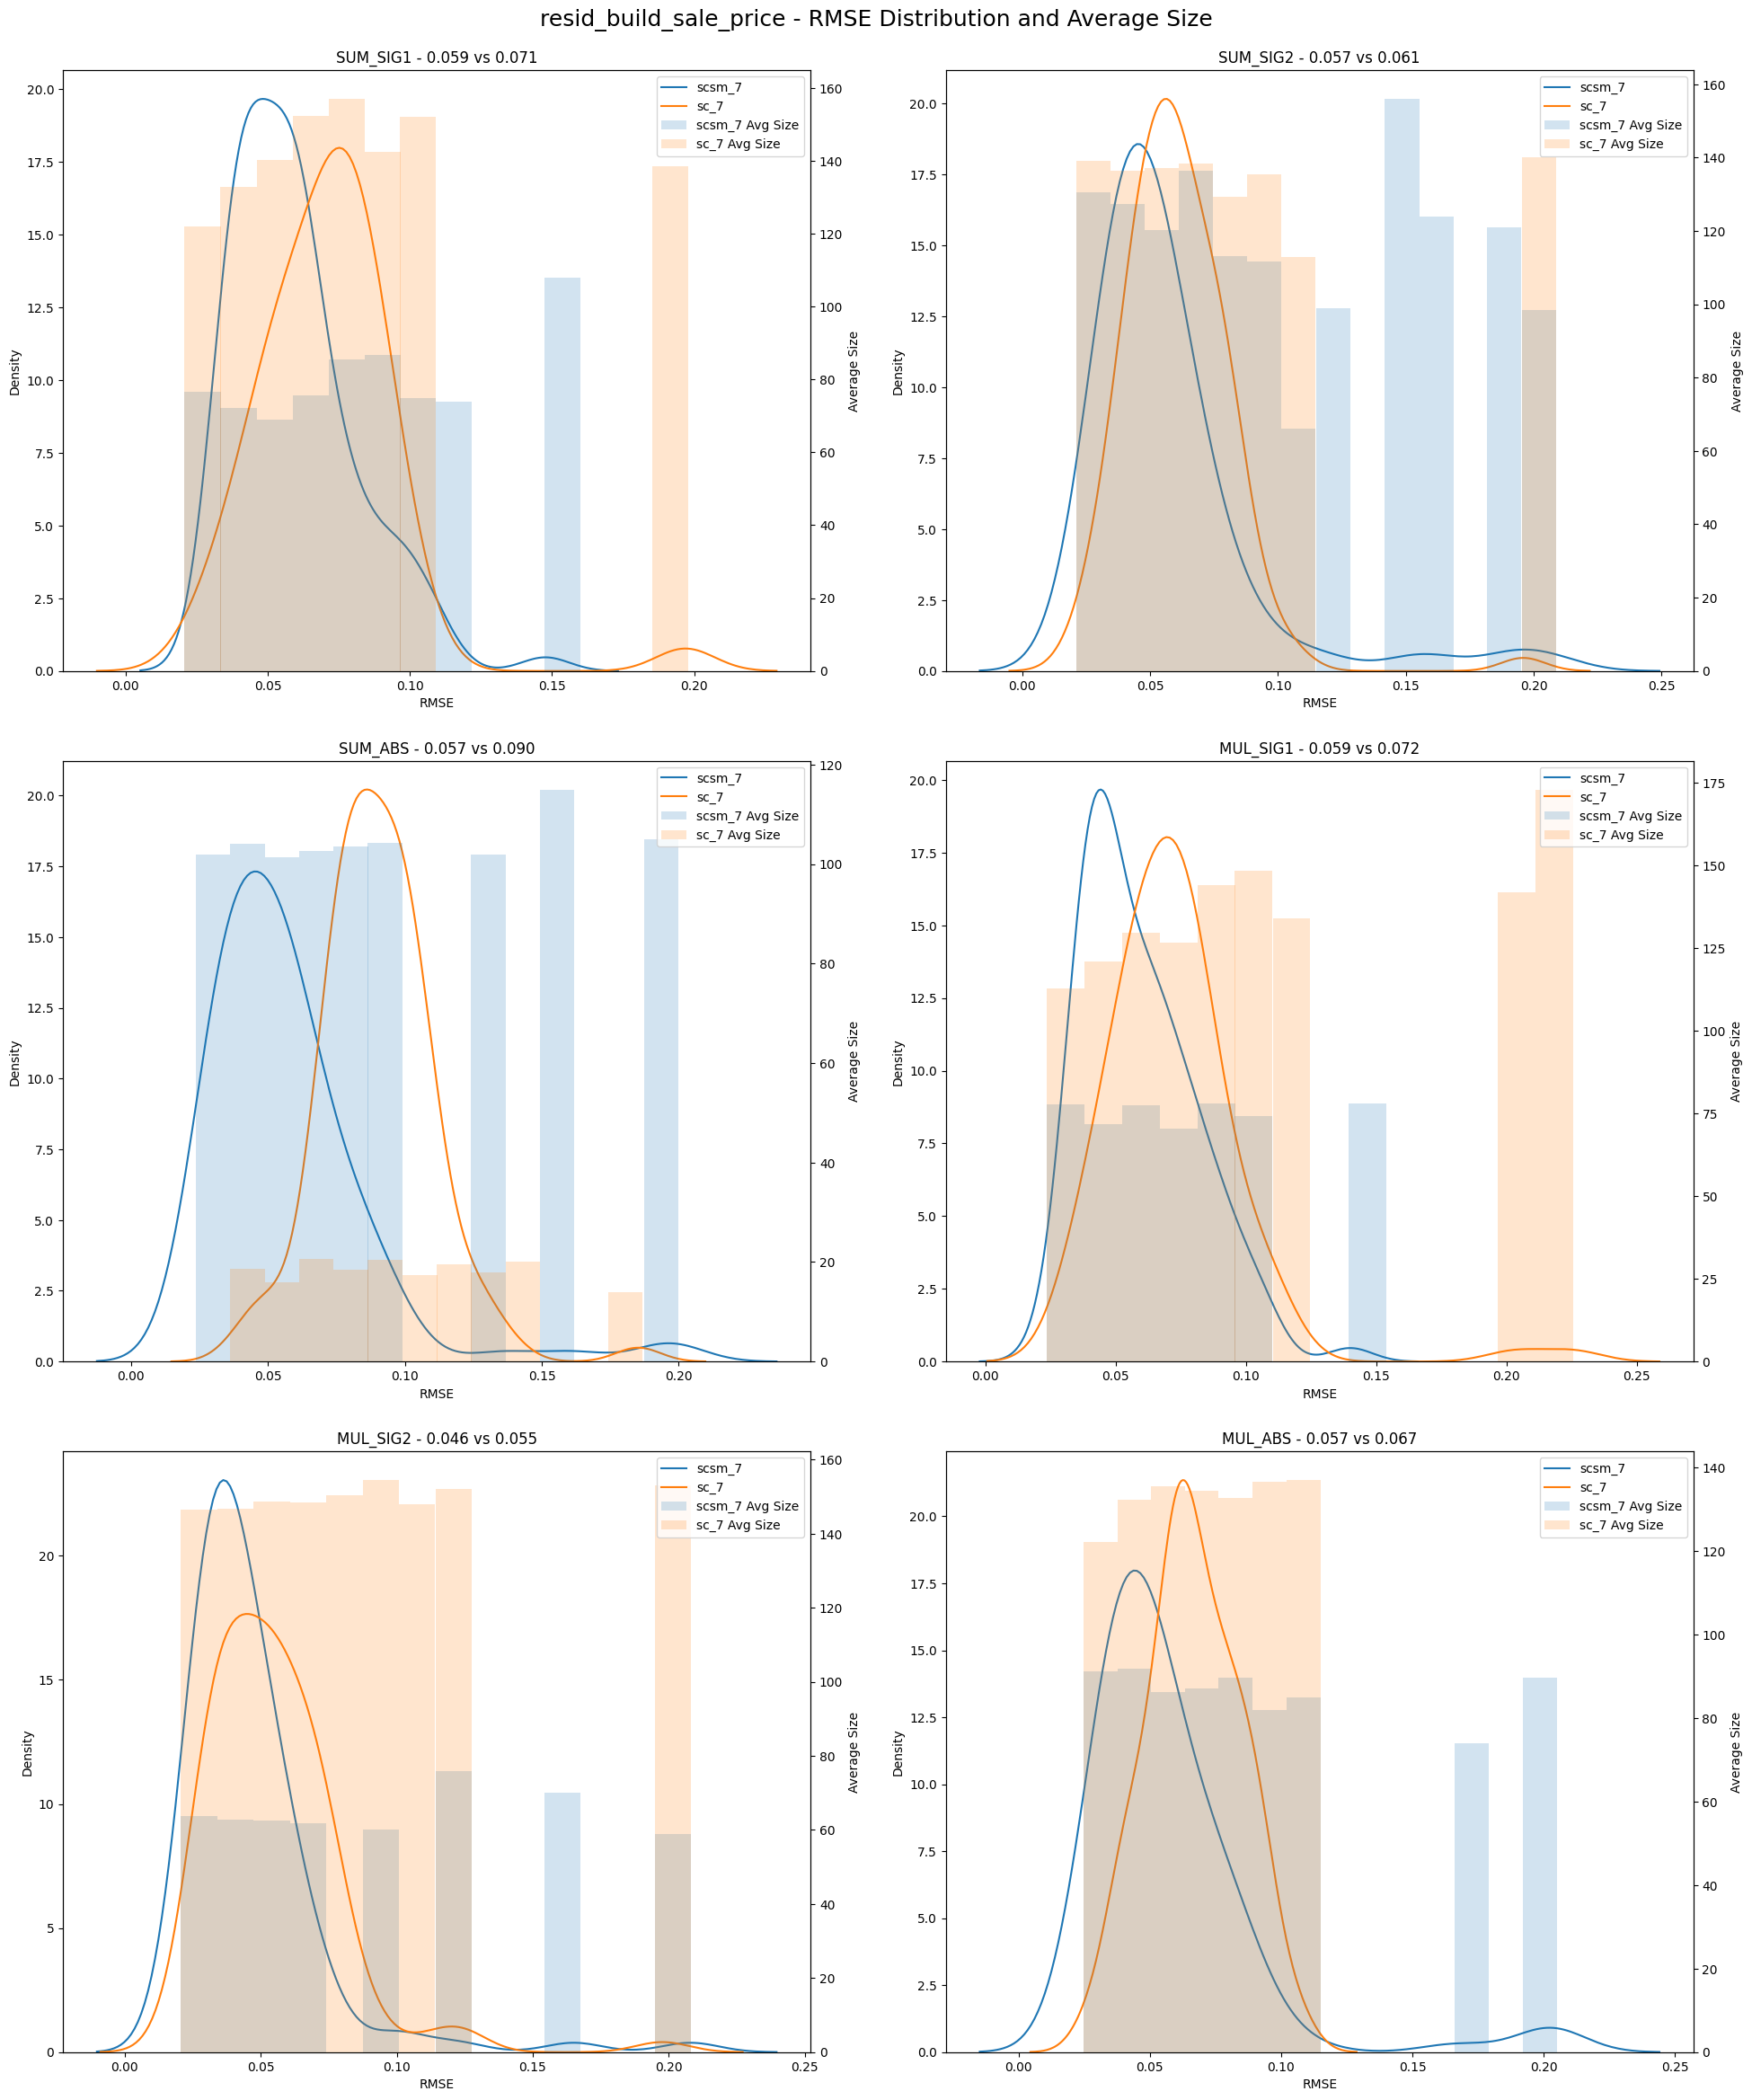

In [ ]:
n_bins = 14
prefixes = ['scsm_7', 'sc_7']
dataset = 'resid_build_sale_price'
best = True

dataset_id = dataset_dict[dataset]
with open(f'results/slim/{dataset_id}/{prefixes[0]}.pkl', 'rb') as f:
    results1 = pickle.load(f)
with open(f'results/slim/{dataset_id}/{prefixes[1]}.pkl', 'rb') as f:
    results2 = pickle.load(f)
algorithms = ['SUM_SIG1', 'SUM_SIG2', 'SUM_ABS', 'MUL_SIG1', 'MUL_SIG2', 'MUL_ABS']

def create_dataframe(results, prefix):
    data = []
    for algo in algorithms:
        for rmse, size in zip(results['rmse'][algo], results['size'][algo]):
            data.append({'algorithm': algo, 'rmse': rmse, 'size': size, 'prefix': prefix})
    return pd.DataFrame(data)

df1 = create_dataframe(results1, prefixes[0])
df2 = create_dataframe(results2, prefixes[1])
df = pd.concat([df1, df2])

def calculate_mean_size(data, bins):
    data = data.copy()
    data['rmse_bin'] = pd.cut(data['rmse'], bins=bins)
    return data.groupby('rmse_bin', observed=False)['size'].mean().reset_index()


fig, axs = plt.subplots(3, 2, figsize=(20, 24))
axs = axs.flatten()

for i, algo in enumerate(algorithms):
    algo_data = df[df['algorithm'] == algo]
    sns.kdeplot(data=algo_data[algo_data['prefix'] == prefixes[0]], x='rmse', ax=axs[i], label=prefixes[0])
    sns.kdeplot(data=algo_data[algo_data['prefix'] == prefixes[1]], x='rmse', ax=axs[i], label=prefixes[1])
    rmse_min = algo_data['rmse'].min()
    rmse_max = algo_data['rmse'].max()
    bins = np.linspace(rmse_min, rmse_max, n_bins+1)
    
    mean_size1 = calculate_mean_size(algo_data[algo_data['prefix'] == prefixes[0]], bins)
    mean_size2 = calculate_mean_size(algo_data[algo_data['prefix'] == prefixes[1]], bins)
    
    ax2 = axs[i].twinx()
    ax2.bar(mean_size1['rmse_bin'].apply(lambda x: x.mid), mean_size1['size'], alpha=0.2, width=(rmse_max-rmse_min)/n_bins, label=f'{prefixes[0]} Avg Size')
    ax2.bar(mean_size2['rmse_bin'].apply(lambda x: x.mid), mean_size2['size'], alpha=0.2, width=(rmse_max-rmse_min)/n_bins, label=f'{prefixes[1]} Avg Size')
    
    axs[i].set_title(f'{algo} - {np.mean(results1["rmse"][algo]):.3f} vs {np.mean(results2["rmse"][algo]):.3f}')
    axs[i].set_xlabel('RMSE')
    axs[i].set_ylabel('Density')
    ax2.set_ylabel('Average Size')
    
    lines1, labels1 = axs[i].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

fig.suptitle(f'{dataset} - RMSE Distribution and Average Size', fontsize=18)
plt.tight_layout(pad=2.5)
plt.show()

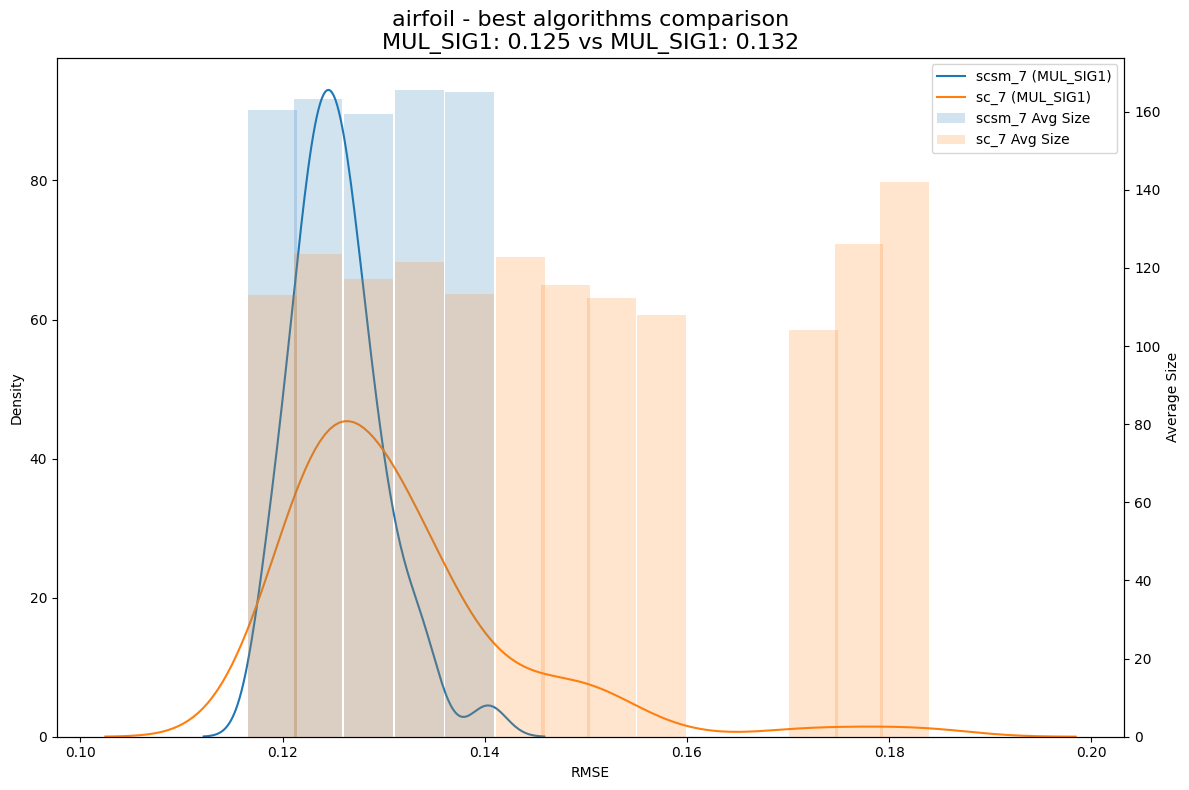

In [23]:
n_bins = 14
prefixes = ['scsm_7', 'sc_7']
# dataset = 'resid_build_sale_price'
dataset = 'airfoil' 

# Annahme: dataset_dict und die Ergebnisdateien sind verfügbar
dataset_id = dataset_dict[dataset]
with open(f'results/slim/{dataset_id}/{prefixes[0]}.pkl', 'rb') as f:
    results1 = pickle.load(f)
with open(f'results/slim/{dataset_id}/{prefixes[1]}.pkl', 'rb') as f:
    results2 = pickle.load(f)
algorithms = ['SUM_SIG1', 'SUM_SIG2', 'SUM_ABS', 'MUL_SIG1', 'MUL_SIG2', 'MUL_ABS']


def create_dataframe(results, prefix):
    data = []
    for algo in algorithms:
        for rmse, size in zip(results['rmse'][algo], results['size'][algo]):
            data.append({'algorithm': algo, 'rmse': rmse, 'size': size, 'prefix': prefix})
    return pd.DataFrame(data)

def calculate_mean_size(data, bins):
    data = data.copy()
    data['rmse_bin'] = pd.cut(data['rmse'], bins=bins)
    return data.groupby('rmse_bin', observed=False)['size'].mean().reset_index()
df1 = create_dataframe(results1, prefixes[0])
df2 = create_dataframe(results2, prefixes[1])
best_algo1 = df1.groupby('algorithm')['rmse'].mean().idxmin()
best_algo2 = df2.groupby('algorithm')['rmse'].mean().idxmin()
best_df1 = df1[df1['algorithm'] == best_algo1]
best_df2 = df2[df2['algorithm'] == best_algo2]
df = pd.concat([best_df1, best_df2])

fig, ax = plt.subplots(figsize=(12, 8))

sns.kdeplot(data=best_df1, x='rmse', ax=ax, label=f'{prefixes[0]} ({best_algo1})')
sns.kdeplot(data=best_df2, x='rmse', ax=ax, label=f'{prefixes[1]} ({best_algo2})')
rmse_min = df['rmse'].min()
rmse_max = df['rmse'].max()
bins = np.linspace(rmse_min, rmse_max, n_bins+1)
mean_size1 = calculate_mean_size(best_df1, bins)
mean_size2 = calculate_mean_size(best_df2, bins)

ax2 = ax.twinx()
ax2.bar(mean_size1['rmse_bin'].apply(lambda x: x.mid), mean_size1['size'], alpha=0.2, width=(rmse_max-rmse_min)/n_bins, label=f'{prefixes[0]} Avg Size')
ax2.bar(mean_size2['rmse_bin'].apply(lambda x: x.mid), mean_size2['size'], alpha=0.2, width=(rmse_max-rmse_min)/n_bins, label=f'{prefixes[1]} Avg Size')
ax.set_xlabel('RMSE')
ax.set_ylabel('Density')
ax2.set_ylabel('Average Size')
plt.title(f'{dataset} - best algorithms comparison\n{best_algo1}: {best_df1["rmse"].mean():.3f} vs {best_algo2}: {best_df2["rmse"].mean():.3f}', fontsize=16)
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.show()


In [22]:
dataset_dict

{'resid_build_sale_price': 'DA00',
 'istanbul': 'DA01',
 'airfoil': 'DA02',
 'bike_sharing': 'DA03',
 'boston': 'DA04',
 'breast_cancer': 'DA05',
 'concrete_slump': 'DA06',
 'concrete_strength': 'DA07',
 'diabetes': 'DA08',
 'efficiency_heating': 'DA09',
 'efficiency_cooling': 'DA10',
 'forest_fires': 'DA11',
 'ld50': 'DA12',
 'ppb': 'DA13',
 'bioav': 'DA14'}

In [24]:
with open('params/DA02/scsm_7.pkl', 'rb') as f:
    params = pickle.load(f)

params['MUL_SIG1']

{'p_inflate': np.float64(0.08),
 'max_depth': 17,
 'init_depth': 4,
 'tournament_size': 3,
 'prob_const': np.float64(0.18),
 'struct_mutation': 0.02,
 'decay_rate': np.float64(0.06),
 'p_struct': np.float64(0.24),
 'depth_distribution': np.str_('exp'),
 'pop_size': 120,
 'n_iter': 900,
 'p_xo': np.float64(0.0),
 'p_struct_xo': np.float64(0.0),
 'simplify_threshold': None}

In [15]:
means_df(prefixes=['scsm_7', 'sc_7'],
         best=True, rmse_compare=False, decimals=4, table=False)

Error in significance test: zero_method 'wilcox' and 'pratt' do not work if x - y is zero for all elements., ld50, SUM_SIG2, sc_7


,rmse_scsm_7,rmse_sc_7,ratio_rmse,rmse_significance,size_scsm_7,size_sc_7,ratio_size,size_significance
bike_sharing,0.0182,0.0384,0.4750,+++,91.46,98.86,0.9251,NSD
resid_build_sale_price,0.0463,0.0548,0.8441,+++,63.08,147.91,0.4265,+++
ppb,0.3174,0.3559,0.8920,NSD,140.94,255.49,0.5516,+++
concrete_strength,0.1033,0.1118,0.9247,+++,218.58,139.42,1.5678,---
efficiency_heating,0.0586,0.0623,0.9408,++,177.87,150.25,1.1838,---
breast_cancer,0.2579,0.2714,0.9501,+++,109.61,134.29,0.8162,+++
airfoil,0.1255,0.1316,0.9535,+++,162.09,119.65,1.3547,---
efficiency_cooling,0.0784,0.0818,0.9588,+,137.84,143.08,0.9634,+
boston,0.1149,0.1187,0.9684,NSD,104.39,73.72,1.4160,---
diabetes,0.1934,0.1950,0.9919,+,139.99,100.02,1.3996,---


In [9]:
with open('params/DA00/scsm_5.pkl', 'rb') as f:
    params = pickle.load(f)['MUL_ABS']

params.pop('simplify_threshold')
X,y = datasets[0]()
X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.2, seed=60)

rm, mp, ma, rm_c, mp_c, ma_c, time_stats, size, reps = test_slim(
            X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, 
            args_dict=params, dataset_name=name, verbose=1,
            n_samples=50, n_elites=1, simplify_threshold=0.02,
            # callbacks=[early_stopping],
        )

  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:30<24:34, 30.10s/it]

Iteration 1/50 - RMSE: 0.1027 - SIZE: 82.0 - MAE: 0.0410 - Time: 30.09s


  4%|▍         | 2/50 [01:00<24:11, 30.24s/it]

Iteration 2/50 - RMSE: 0.0535 - SIZE: 85.0 - MAE: 0.0315 - Time: 30.33s


  6%|▌         | 3/50 [01:31<23:49, 30.41s/it]

Iteration 3/50 - RMSE: 0.0496 - SIZE: 80.0 - MAE: 0.0280 - Time: 30.61s


  8%|▊         | 4/50 [02:01<23:18, 30.41s/it]

Iteration 4/50 - RMSE: 0.0364 - SIZE: 81.0 - MAE: 0.0254 - Time: 30.40s


 10%|█         | 5/50 [02:34<23:26, 31.25s/it]

Iteration 5/50 - RMSE: 0.0569 - SIZE: 94.0 - MAE: 0.0304 - Time: 32.72s


 12%|█▏        | 6/50 [03:04<22:47, 31.08s/it]

Iteration 6/50 - RMSE: 0.0354 - SIZE: 91.0 - MAE: 0.0277 - Time: 30.75s


 14%|█▍        | 7/50 [03:36<22:17, 31.11s/it]

Iteration 7/50 - RMSE: 0.0432 - SIZE: 69.0 - MAE: 0.0294 - Time: 31.17s


 16%|█▌        | 8/50 [04:05<21:30, 30.72s/it]

Iteration 8/50 - RMSE: 0.0426 - SIZE: 71.0 - MAE: 0.0282 - Time: 29.87s


 18%|█▊        | 9/50 [04:36<20:51, 30.54s/it]

Iteration 9/50 - RMSE: 0.0359 - SIZE: 84.0 - MAE: 0.0246 - Time: 30.12s


 20%|██        | 10/50 [05:06<20:19, 30.50s/it]

Iteration 10/50 - RMSE: 0.0614 - SIZE: 93.0 - MAE: 0.0412 - Time: 30.41s


 22%|██▏       | 11/50 [05:37<19:50, 30.53s/it]

Iteration 11/50 - RMSE: 0.0343 - SIZE: 57.0 - MAE: 0.0235 - Time: 30.57s


 24%|██▍       | 12/50 [06:06<19:11, 30.32s/it]

Iteration 12/50 - RMSE: 0.0389 - SIZE: 71.0 - MAE: 0.0288 - Time: 29.83s


 26%|██▌       | 13/50 [06:36<18:29, 29.98s/it]

Iteration 13/50 - RMSE: 0.0477 - SIZE: 86.0 - MAE: 0.0394 - Time: 29.21s


 28%|██▊       | 14/50 [07:07<18:12, 30.35s/it]

Iteration 14/50 - RMSE: 0.0470 - SIZE: 95.0 - MAE: 0.0270 - Time: 31.20s


 30%|███       | 15/50 [07:37<17:40, 30.29s/it]

Iteration 15/50 - RMSE: 0.0851 - SIZE: 72.0 - MAE: 0.0423 - Time: 30.15s


 32%|███▏      | 16/50 [08:07<17:10, 30.32s/it]

Iteration 16/50 - RMSE: 0.0665 - SIZE: 72.0 - MAE: 0.0361 - Time: 30.37s


 34%|███▍      | 17/50 [08:37<16:33, 30.10s/it]

Iteration 17/50 - RMSE: 0.0286 - SIZE: 60.0 - MAE: 0.0209 - Time: 29.60s


 36%|███▌      | 18/50 [09:06<15:57, 29.91s/it]

Iteration 18/50 - RMSE: 0.0899 - SIZE: 68.0 - MAE: 0.0433 - Time: 29.46s


 38%|███▊      | 19/50 [09:35<15:17, 29.59s/it]

Iteration 19/50 - RMSE: 0.0359 - SIZE: 74.0 - MAE: 0.0264 - Time: 28.84s


 40%|████      | 20/50 [10:05<14:45, 29.52s/it]

Iteration 20/50 - RMSE: 0.0592 - SIZE: 70.0 - MAE: 0.0388 - Time: 29.34s


 42%|████▏     | 21/50 [10:34<14:14, 29.47s/it]

Iteration 21/50 - RMSE: 0.0404 - SIZE: 82.0 - MAE: 0.0282 - Time: 29.35s


 44%|████▍     | 22/50 [11:05<13:53, 29.77s/it]

Iteration 22/50 - RMSE: 0.0817 - SIZE: 71.0 - MAE: 0.0489 - Time: 30.47s


 46%|████▌     | 23/50 [11:34<13:24, 29.79s/it]

Iteration 23/50 - RMSE: 0.0626 - SIZE: 87.0 - MAE: 0.0349 - Time: 29.84s


 48%|████▊     | 24/50 [12:06<13:09, 30.37s/it]

Iteration 24/50 - RMSE: 0.0486 - SIZE: 82.0 - MAE: 0.0347 - Time: 31.72s


 50%|█████     | 25/50 [12:36<12:35, 30.23s/it]

Iteration 25/50 - RMSE: 0.0519 - SIZE: 76.0 - MAE: 0.0272 - Time: 29.90s


 52%|█████▏    | 26/50 [13:07<12:08, 30.37s/it]

Iteration 26/50 - RMSE: 0.0495 - SIZE: 84.0 - MAE: 0.0345 - Time: 30.67s


 54%|█████▍    | 27/50 [13:36<11:33, 30.15s/it]

Iteration 27/50 - RMSE: 0.0303 - SIZE: 80.0 - MAE: 0.0220 - Time: 29.63s


 56%|█████▌    | 28/50 [14:06<10:59, 29.97s/it]

Iteration 28/50 - RMSE: 0.0331 - SIZE: 61.0 - MAE: 0.0243 - Time: 29.56s


 58%|█████▊    | 29/50 [14:36<10:28, 29.93s/it]

Iteration 29/50 - RMSE: 0.0284 - SIZE: 72.0 - MAE: 0.0215 - Time: 29.83s


 60%|██████    | 30/50 [15:06<10:02, 30.13s/it]

Iteration 30/50 - RMSE: 0.0762 - SIZE: 82.0 - MAE: 0.0410 - Time: 30.58s


 62%|██████▏   | 31/50 [15:36<09:28, 29.92s/it]

Iteration 31/50 - RMSE: 0.0466 - SIZE: 20.0 - MAE: 0.0343 - Time: 29.43s


 64%|██████▍   | 32/50 [16:06<09:01, 30.06s/it]

Iteration 32/50 - RMSE: 0.0858 - SIZE: 69.0 - MAE: 0.0494 - Time: 30.37s


 66%|██████▌   | 33/50 [16:35<08:27, 29.83s/it]

Iteration 33/50 - RMSE: 0.0290 - SIZE: 59.0 - MAE: 0.0211 - Time: 29.31s


 68%|██████▊   | 34/50 [17:06<07:59, 29.99s/it]

Iteration 34/50 - RMSE: 0.0536 - SIZE: 56.0 - MAE: 0.0287 - Time: 30.36s


 70%|███████   | 35/50 [17:35<07:28, 29.90s/it]

Iteration 35/50 - RMSE: 0.0447 - SIZE: 74.0 - MAE: 0.0330 - Time: 29.67s


 72%|███████▏  | 36/50 [18:07<07:04, 30.31s/it]

Iteration 36/50 - RMSE: 0.0448 - SIZE: 82.0 - MAE: 0.0300 - Time: 31.27s


 74%|███████▍  | 37/50 [18:36<06:29, 29.96s/it]

Iteration 37/50 - RMSE: 0.0481 - SIZE: 65.0 - MAE: 0.0308 - Time: 29.14s


 76%|███████▌  | 38/50 [19:05<05:57, 29.83s/it]

Iteration 38/50 - RMSE: 0.0678 - SIZE: 70.0 - MAE: 0.0412 - Time: 29.50s


 78%|███████▊  | 39/50 [19:35<05:27, 29.77s/it]

Iteration 39/50 - RMSE: 0.0362 - SIZE: 80.0 - MAE: 0.0252 - Time: 29.62s


 80%|████████  | 40/50 [20:05<04:58, 29.87s/it]

Iteration 40/50 - RMSE: 0.0605 - SIZE: 71.0 - MAE: 0.0401 - Time: 30.12s


 82%|████████▏ | 41/50 [20:35<04:29, 29.93s/it]

Iteration 41/50 - RMSE: 0.0696 - SIZE: 70.0 - MAE: 0.0424 - Time: 30.06s


 84%|████████▍ | 42/50 [21:06<04:02, 30.33s/it]

Iteration 42/50 - RMSE: 0.0535 - SIZE: 72.0 - MAE: 0.0419 - Time: 31.26s


 86%|████████▌ | 43/50 [21:38<03:34, 30.60s/it]

Iteration 43/50 - RMSE: 0.0439 - SIZE: 69.0 - MAE: 0.0296 - Time: 31.22s


 88%|████████▊ | 44/50 [22:09<03:04, 30.73s/it]

Iteration 44/50 - RMSE: 0.0433 - SIZE: 72.0 - MAE: 0.0325 - Time: 31.02s


 90%|█████████ | 45/50 [22:39<02:32, 30.58s/it]

Iteration 45/50 - RMSE: 0.0376 - SIZE: 93.0 - MAE: 0.0230 - Time: 30.22s


 92%|█████████▏| 46/50 [23:10<02:02, 30.57s/it]

Iteration 46/50 - RMSE: 0.0297 - SIZE: 89.0 - MAE: 0.0202 - Time: 30.55s


 94%|█████████▍| 47/50 [23:39<01:31, 30.38s/it]

Iteration 47/50 - RMSE: 0.0513 - SIZE: 69.0 - MAE: 0.0316 - Time: 29.91s


 96%|█████████▌| 48/50 [24:09<01:00, 30.19s/it]

Iteration 48/50 - RMSE: 0.0360 - SIZE: 65.0 - MAE: 0.0265 - Time: 29.74s


 98%|█████████▊| 49/50 [24:38<00:29, 29.89s/it]

Iteration 49/50 - RMSE: 0.0322 - SIZE: 44.0 - MAE: 0.0235 - Time: 29.19s


100%|██████████| 50/50 [25:08<00:00, 30.18s/it]

Iteration 50/50 - RMSE: 0.0322 - SIZE: 57.0 - MAE: 0.0241 - Time: 29.87s


In [268]:
means_df(prefixes=['scsmsp_5', 'scsm_5'],
         best=True, rmse_compare=False, decimals=4, table=True)

╒════════════════════════╤═════════════════╤═════════════════╤══════════════╤═════════════════════╤══════════════════╤══════════════════╤══════════════╤═════════════════════╕
│                        │ rmse_scsmsp_5   │ rmse_scsm_5     │   ratio_rmse │ rmse_significance   │ size_scsmsp_5    │ size_scsm_5      │   ratio_size │ size_significance   │
╞════════════════════════╪═════════════════╪═════════════════╪══════════════╪═════════════════════╪══════════════════╪══════════════════╪══════════════╪═════════════════════╡
│ resid_build_sale_price │ 0.0464 ± 0.0142 │ 0.0495 ± 0.0149 │       0.9374 │ NSD                 │ 94.58 ± 16.4512  │ 74.26 ± 12.8138  │       1.2736 │ ---                 │
├────────────────────────┼─────────────────┼─────────────────┼──────────────┼─────────────────────┼──────────────────┼──────────────────┼──────────────┼─────────────────────┤
│ concrete_slump         │ 0.2498 ± 0.0206 │ 0.2581 ± 0.0418 │       0.9679 │ NSD                 │ 86.42 ± 28.6043  │ 72.86 

In [190]:
means_df(prefixes=['scsm_3', 'sc_3'],
         best=False, rmse_compare=False, decimals=4, table=False)

rmse_scsm_4  rmse_sc_4  size_scsm_4  \
Dataset                Algorithm                                        
bike_sharing           MUL_SIG2        0.0290     0.0857       156.86   
                       MUL_SIG1        0.0229     0.0566        97.44   
                       SUM_SIG1        0.0245     0.0519        74.26   
resid_build_sale_price MUL_SIG1        0.0470     0.0856       109.94   
efficiency_heating     MUL_SIG2        0.0781     0.1251       162.50   
...                                       ...        ...          ...   
breast_cancer          SUM_SIG1        0.3082     0.2777       157.56   
ld50                   MUL_SIG1        0.2475     0.2225        50.74   
bioav                  MUL_SIG1        0.3584     0.3215        49.90   
ld50                   MUL_ABS         0.2703     0.2229        61.88   
resid_build_sale_price MUL_ABS         0.1084     0.0743       141.90   

                                  size_sc_4  ratio_rmse  ratio_size  \
Dataset                Algorithm                                      
bike_sharing           MUL_SIG2       47.24      0.3383      3.3205   
                       MUL_SIG1      135.82      0.4054      0.7174   
                       SUM_SIG1       98.78      0.4710      0.7518   
resid_build_sale_price MUL_SIG1       31.30      0.5497      3.5125   
efficiency_heating     MUL_SIG2       17.04      0.6242      9.5364   
...                                     ...         ...         ...   
breast_cancer          SUM_SIG1      322.76      1.1098      0.4882   
ld50                   MUL_SIG1       46.90      1.1124      1.0819   
bioav                  MUL_SIG1       30.26      1.1149      1.6490   
ld50                   MUL_ABS        17.24      1.2126      3.5893   
resid_build_sale_price MUL_ABS       110.94      1.4579      1.2791   

                                 rmse_significance size_significance  
Dataset                Algorithm                                      
bike_sharing           MUL_SIG2                +++               ---  
                       MUL_SIG1                +++                ++  
                       SUM_SIG1                +++               +++  
resid_build_sale_price MUL_SIG1                +++               ---  
efficiency_heating     MUL_SIG2                +++               ---  
...                                            ...               ...  
breast_cancer          SUM_SIG1                ---               +++  
ld50                   MUL_SIG1                NSD                --  
bioav                  MUL_SIG1                NSD               ---  
ld50                   MUL_ABS                 NSD               ---  
resid_build_sale_price MUL_ABS                 ---                --  

[90 rows x 8 columns]

In [197]:
means_df(prefixes=['scsmsp_4', 'scsm_4'],
         best=False, rmse_compare=False, decimals=4, table=False).value_counts('size_significance')

size_significance
+++    61
---    11
NSD    10
+       3
-       3
++      2
Name: count, dtype: int64

In [193]:
means_df(prefixes=['scsm_4', 'sc_4'],
         best=True, rmse_compare=False, decimals=4, table=False)

,rmse_scsm_4,rmse_sc_4,ratio_rmse,rmse_significance,size_scsm_4,size_sc_4,ratio_size,size_significance
bike_sharing,0.0229,0.0428,0.5359,+++,97.44,128.62,0.7576,+++
resid_build_sale_price,0.0451,0.0578,0.7805,++,208.32,113.90,1.8290,---
boston,0.1344,0.1498,0.8971,+++,191.88,88.26,2.1740,---
efficiency_cooling,0.0828,0.0920,0.9006,+++,177.12,230.64,0.7680,+++
efficiency_heating,0.0737,0.0812,0.9074,+,152.86,84.00,1.8198,---
airfoil,0.1210,0.1284,0.9424,+++,181.12,88.64,2.0433,---
istanbul,0.0761,0.0782,0.9727,+,75.92,43.96,1.7270,---
bioav,0.3168,0.3215,0.9856,NSD,18.16,30.26,0.6001,+++
forest_fires,0.2332,0.2364,0.9865,NSD,88.74,16.88,5.2571,---
diabetes,0.1799,0.1820,0.9880,NSD,103.38,159.74,0.6472,+++


In [240]:
df = means_df(prefixes=['scsm', 'sc'],
         best=True, rmse_compare=False, decimals=4, table=False)

df

,rmse_scsm,rmse_sc,ratio_rmse,rmse_significance,size_scsm,size_sc,ratio_size,size_significance
bike_sharing,0.0217,0.0291,0.7434,+,92.3333,183.9333,0.5020,+++
resid_build_sale_price,0.0371,0.0449,0.8268,++,91.6667,247.6667,0.3701,+++
concrete_strength,0.0924,0.1086,0.8507,+++,206.8333,167.5000,1.2348,---
boston,0.0853,0.0960,0.8888,++,92.1000,183.0667,0.5031,+++
airfoil,0.1184,0.1304,0.9077,++,98.0333,168.2000,0.5828,+++
concrete_slump,0.2689,0.2896,0.9286,+,90.7333,86.1333,1.0534,NSD
bioav,0.2485,0.2635,0.9431,+,98.3667,97.2333,1.0117,NSD
ppb,0.2622,0.2692,0.9737,NSD,94.9333,89.0667,1.0659,NSD
breast_cancer,0.2393,0.2420,0.9889,NSD,96.3000,163.0333,0.5907,+++
istanbul,0.0626,0.0633,0.9895,NSD,91.0333,148.9667,0.6111,+++


In [49]:
df = means_df(prefixes=['scsm', 'sc'],
         best=False, rmse_compare=False, decimals=4, table=False)

# For each dataset, apply a scaler to the rmse_scsm and rmse_sc columns
maxs = df.groupby('Dataset').max()[['rmse_scsm', 'rmse_sc']].max(axis=1)
mins = df.groupby('Dataset').min()[['rmse_scsm', 'rmse_sc']].min(axis=1)
df['rmse_scsm_scaled'] = (df['rmse_scsm'] - mins) / (maxs - mins)
df['rmse_sc_scaled'] = (df['rmse_sc'] - mins) / (maxs - mins)

# Scale the sizes
maxs = df.groupby('Dataset').max()[['size_scsm', 'size_sc']].max(axis=1)
mins = df.groupby('Dataset').min()[['size_scsm', 'size_sc']].min(axis=1)
df['size_scsm_scaled'] = (df['size_scsm'] - mins) / (maxs - mins)
df['size_sc_scaled'] = (df['size_sc'] - mins) / (maxs - mins)

# Create a score column
df['score_scsm'] = df['rmse_scsm_scaled'] + 0.5 * df['size_scsm_scaled']
df['score_sc'] = df['rmse_sc_scaled'] + 0.5 * df['size_sc_scaled']

# Drop the scaled columns
df.drop(columns=['rmse_scsm_scaled', 'rmse_sc_scaled', 'size_scsm_scaled', 'size_sc_scaled'], inplace=True)

In [56]:
# Get, for each dataset the best algorithm
best_indices = df.groupby('Dataset')[['score_scsm', 'score_sc']].idxmin().values.flatten()
best_df = df.loc[best_indices]

# For which datasets is scsm better than sc? Youll need to pivot the table
df

rmse_scsm  rmse_sc  size_scsm   size_sc  \
Dataset            Algorithm                                            
bike_sharing       SUM_SIG2      0.0269   0.0580    85.7000  150.0000   
                   MUL_ABS       0.0341   0.0627    86.8333   77.1000   
                   MUL_SIG2      0.0225   0.0405    87.0333   80.3000   
                   MUL_SIG1      0.0299   0.0528    90.0667  150.0333   
ppb                MUL_SIG1      0.2841   0.4905    91.8000  181.4333   
...                                 ...      ...        ...       ...   
istanbul           MUL_SIG1      0.0738   0.0633    91.7000  148.9667   
efficiency_cooling SUM_ABS       0.0847   0.0705    95.1000  278.6667   
ppb                SUM_ABS       0.3847   0.2692    87.3667   89.0667   
                   SUM_SIG1      0.4478   0.2730    89.7000  172.9000   
                   MUL_ABS       0.4868   0.2816    99.0000   87.2667   

                              ratio_rmse  ratio_size  score_scsm  score_sc  \
Dataset            Algorithm                                                 
bike_sharing       SUM_SIG2       0.4628      0.5713    0.167079  1.226552   
                   MUL_ABS        0.5429      1.1262    0.347993  1.000000   
                   MUL_SIG2       0.5555      1.0839    0.066002  0.473513   
                   MUL_SIG1       0.5663      0.6003    0.260687  1.099878   
ppb                MUL_SIG1       0.5793      0.5060    0.119997  1.500000   
...                                  ...         ...         ...       ...   
istanbul           MUL_SIG1       1.1668      0.6156    1.052737  0.497525   
efficiency_cooling SUM_ABS        1.2018      0.3413    0.531005  0.500000   
ppb                SUM_ABS        1.4288      0.9809    0.537106  0.040219   
                   SUM_SIG1       1.6402      0.5188    0.825886  0.501997   
                   MUL_ABS        1.7288      1.1345    1.046094  0.084976   

                              scsm_better  
Dataset            Algorithm               
bike_sharing       SUM_SIG2          True  
                   MUL_ABS           True  
                   MUL_SIG2          True  
                   MUL_SIG1          True  
ppb                MUL_SIG1          True  
...                                   ...  
istanbul           MUL_SIG1         False  
efficiency_cooling SUM_ABS          False  
ppb                SUM_ABS          False  
                   SUM_SIG1         False  
                   MUL_ABS          False  

[90 rows x 9 columns]

### PARAMS